# Pretraining with contractive and margin losses

## 1. Import libraries

In [3]:
import os
import pandas as pd
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import coma
print(coma.__version__)

2.0.0


In [5]:
from coma.dataset import TrainingSmilesDataset, ValidationSmilesDataset
from coma.vae import SmilesAutoencoder

## 2. Configure GPU (if available)

In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print(device)

cuda:0


## 3. Set a target property

In [7]:
import pandas
df = pd.read_csv('/home/yagr/Hacathon/COMA/data/AODB_results.csv')
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.upper()
df



,SMILES,Activity_umolequiv_per_umol
0,COC1CCC(C2C=C(C3CCCC4CCCCC34)NC3NNCN32)CC1,0.446
1,C1COC(-C2CC(-C3CCCC4CCCCC34)NC3NNCN23)C1,0.101
2,CN(C)C1CCC(-C2CC(-C3CCCC4CCCCC34)NC3NNCN23)CC1,0.171
3,COC1CCC(-C2CC(-C3CCCC4CCCCC34)NC3NNCN23)CC1OC,0.234
4,C1CCC(-C2CC(-C3CCCC4CCCCC34)NC3NNCN23)CC1,0.301
...,...,...
1117,COC1CCC(NC2NC(CL)NC(NC3CCCC(C(F)(F)F)C3)N2)CC1,1.830
1118,FC1CCC(NC2NC(CL)NC(NC3CCCC(C(F)(F)F)C3)N2)CC1CL,1.220
1119,CC1CCC(NC2NC(CL)NC(NC3CCC(F)C(CL)C3)N2)CC1,1.620
1120,COC1CCC(NC2NC(CL)NC(NC3CCC(F)C(CL)C3)N2)CC1,1.780


In [8]:
from rdkit import Chem
import pandas
df = pd.read_csv('/home/yagr/Hacathon/COMA/data/AODB_results.csv')
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.upper()
df


def contains_only_desired_atoms(smiles, desired_atoms=['C', 'H', 'O', 'N', 'P', 'S']):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        
        # Получаем все атомы в молекуле
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        # Проверяем, что все атомы входят в список желаемых
        return all(atom in desired_atoms for atom in atoms)
    except:
        return False

# Применяем фильтр к набору SMILES
filtered_smiles = [s for s in df['SMILES'] if contains_only_desired_atoms(s)]
df = df[df['SMILES'].isin(filtered_smiles)]
df = df.sort_values(by='Activity_umolequiv_per_umol',ascending=False)
df

,SMILES,Activity_umolequiv_per_umol
546,CC1CCC2[NH]C3C(C2C1)CCC1C-3NC(N)C(C#N)C1-C1CCC...,1500.0000
893,N[C@@H](CC1CCC(O)CC1)C(=O)N[C@@H](CCC(=O)O)C(=...,1100.1300
895,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,850.1800
363,CC1CCC(C(O)CNC(=O)CC2CCCNC2)CC1,500.0000
362,COC1CC(/C=C/C(=O)NCC(O)C2CCC(C)CC2)CCC1O,500.0000
...,...,...
685,O=C1CCC2CC(O)C(O)CC2O1,0.0500
890,CC(C)C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)NCC(=O)O,0.0300
888,CC(C)[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](C...,0.0300
202,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,0.0250


Метрики модели:
R2 score: 0.6754
RMSE: 71.7265
Pearson correlation: 0.8403


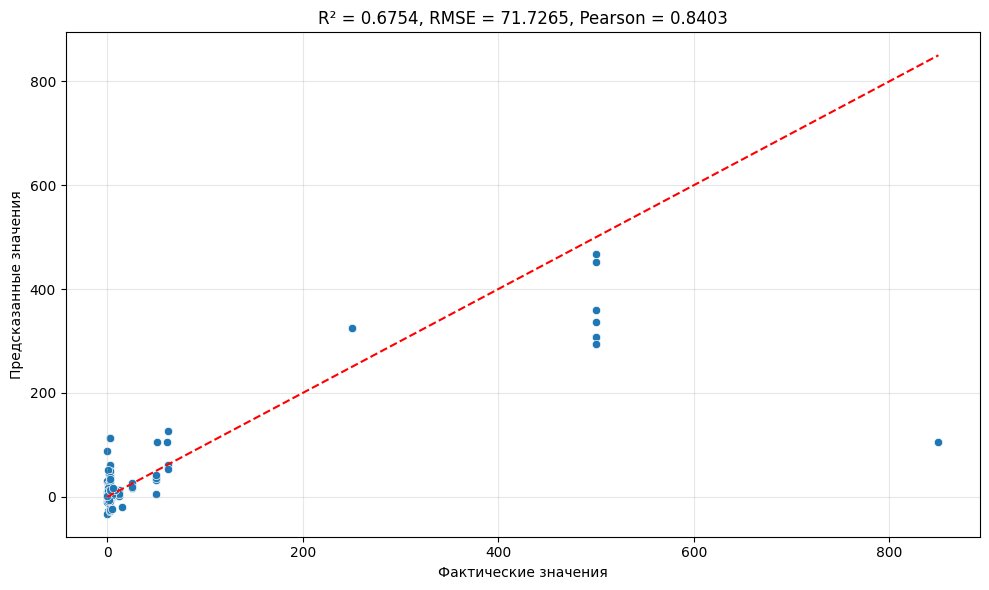

In [9]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Функция для преобразования SMILES в Morgan fingerprints
def smiles_to_morgan(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return np.array(fingerprint)

# Подготовка данных
def prepare_data(df, smiles_col, target_col, test_size=0.2, random_state=42):
    # Преобразование SMILES в Morgan fingerprints
    X_data = []
    valid_indices = []
    
    for idx, smiles in enumerate(df[smiles_col].values):
        fp = smiles_to_morgan(smiles)
        if fp is not None:
            X_data.append(fp)
            valid_indices.append(idx)
    
    X_data = np.array(X_data)
    y_data = df.iloc[valid_indices][target_col].values
    
    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=test_size, random_state=random_state
    )
    
    scaler = StandardScaler()

    return X_train, X_test, y_train, y_test

# Модель LightGBM
def train_lightgbm_model(X_train, X_test, y_train, y_test):
    # Создаем датасеты LightGBM
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)
    
    # Параметры модели
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1
    }
    
    # Обучение модели
    model = lgb.train(
        params,
        train_data,
        valid_sets=[test_data],
    )
    
    return model

# Оценка метрик
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    # Расчет метрик
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    pearson_corr, _ = pearsonr(y_test, y_pred)
    
    metrics = {
        'R2': r2,
        'RMSE': rmse,
        'Pearson': pearson_corr
    }
    
    return metrics, y_pred

# Основная функция
def run_lightgbm_regression(df, smiles_column, target_column):
    # Подготовка данных
    X_train, X_test, y_train, y_test = prepare_data(df, smiles_column, target_column)
    
    # Обучение модели
    model = train_lightgbm_model(X_train, X_test, y_train, y_test)
    
    # Оценка модели
    metrics, y_pred = evaluate_model(model, X_test, y_test)
    
    print("Метрики модели:")
    print(f"R2 score: {metrics['R2']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"Pearson correlation: {metrics['Pearson']:.4f}")
    
    # Создаем DataFrame с результатами
    results_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    return model, metrics, results_df

# Визуализация результатов
def plot_results(actual, predicted, metrics):
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=actual, y=predicted)
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], 'r--')
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные значения')
    plt.title(f'R² = {metrics["R2"]:.4f}, RMSE = {metrics["RMSE"]:.4f}, Pearson = {metrics["Pearson"]:.4f}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Пример использования:
# df = pd.read_csv('your_data.csv')
model, metrics, results = run_lightgbm_regression(df, 'SMILES', 'Activity_umolequiv_per_umol')
plot_results(results['Actual'], results['Predicted'], metrics)

In [10]:
df_test = pd.read_csv('/home/yagr/Hacathon/COMA/data/quantitive_neftekod25_data.csv')
test_smiles = df_test['SMILES'].unique()

test_smiles

array(['C1=CC=C(C=C1)NC2=CC=CC=C2',
       'CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32',
       'C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC',
       'C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32', 'CC1=C(C(=CC=C1)O)C',
       'CC1=CC(=C(C=C1)C)O', 'CC1=C(C=C(C=C1)O)C', 'CC1=CC(=CC(=C1)O)C',
       'CCC1=CC=C(C=C1)O', 'CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C',
       'CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O',
       'CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C',
       'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]'], dtype=object)

In [11]:
# Создаем новую колонку Norm как отношение PDSC/C
df_test['Norm'] = df_test['PDSC'] / df_test['C']

# Группируем данные по SMILES и вычисляем среднее значение Norm для каждого уникального SMILES
df_unique_smiles = df_test.groupby('SMILES')['Norm'].mean().reset_index()

# Выводим результаты
print(f"Исходный датафрейм: {df_test.shape[0]} строк")
print(f"Датафрейм с уникальными SMILES: {df_unique_smiles.shape[0]} строк")

# Пример первых нескольких строк из каждого датафрейма
print("\nИсходный датафрейм (первые 5 строк):")
print(df_test[['SMILES', 'C', 'PDSC', 'Norm']].head())

print("\nДатафрейм с уникальными SMILES (первые 5 строк):")
print(df_unique_smiles.head())

Исходный датафрейм: 55 строк
Датафрейм с уникальными SMILES: 13 строк

Исходный датафрейм (первые 5 строк):
                      SMILES         C  PDSC       Norm
0  C1=CC=C(C=C1)NC2=CC=CC=C2  0.059689   1.6  26.805557
1  C1=CC=C(C=C1)NC2=CC=CC=C2  0.120596   2.6  21.559520
2  C1=CC=C(C=C1)NC2=CC=CC=C2  0.182759   5.0  27.358365
3  C1=CC=C(C=C1)NC2=CC=CC=C2  0.246218   9.1  36.959177
4  C1=CC=C(C=C1)NC2=CC=CC=C2  0.311012  14.0  45.014382

Датафрейм с уникальными SMILES (первые 5 строк):
                                              SMILES        Norm
0     C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]  180.200563
1   C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC  214.041839
2                  C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32  731.344892
3                          C1=CC=C(C=C1)NC2=CC=CC=C2   35.781639
4  CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C...  992.272526


In [12]:
def predict_for_new_molecules(model, smiles_list):
    X_new = []
    valid_smiles = []
    invalid_smiles = []
    
    for smiles in smiles_list:
        fp = smiles_to_morgan(smiles)
        if fp is not None:
            X_new.append(fp)
            valid_smiles.append(smiles)
        else:
            invalid_smiles.append(smiles)
    
    if not X_new:
        return pd.DataFrame()
    
    X_new = np.array(X_new)
    predictions = model.predict(X_new)
    
    results_df = pd.DataFrame({
        'SMILES': valid_smiles,
        'Predicted': predictions
    })
    
    if invalid_smiles:
        print(f"Предупреждение: {len(invalid_smiles)} SMILES строк не удалось преобразовать.")
    
    return results_df

t = predict_for_new_molecules(model, df_unique_smiles['SMILES'])
t['NORM']=df_unique_smiles['Norm']
t.sort_values('NORM')

,SMILES,Predicted,NORM
11,CC1=CC(=CC(=C1)O)C,8.672227,11.675500
12,CCC1=CC=C(C=C1)O,11.210459,12.220670
7,CC1=C(C=C(C=C1)O)C,8.672227,12.766451
10,CC1=CC(=C(C=C1)C)O,8.672227,15.807188
6,CC1=C(C(=CC=C1)O)C,5.791605,15.911641
3,C1=CC=C(C=C1)NC2=CC=CC=C2,1.392674,35.781639
0,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H],-12.330941,180.200563
8,CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C,5.791605,202.755677
1,C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC,10.883050,214.041839
2,C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32,12.483941,731.344892


In [106]:
list(t.sort_values('NORM')['SMILES'])

['CC1=CC(=CC(=C1)O)C',
 'CCC1=CC=C(C=C1)O',
 'CC1=C(C=C(C=C1)O)C',
 'CC1=CC(=C(C=C1)C)O',
 'CC1=C(C(=CC=C1)O)C',
 'C1=CC=C(C=C1)NC2=CC=CC=C2',
 'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]',
 'CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C',
 'C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC',
 'C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32',
 'CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C',
 'CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32',
 'CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O']

In [13]:
from rdkit import Chem
import pandas
df = pd.read_csv('/home/yagr/Hacathon/COMA/data/AODB_results.csv')
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].str.upper()
df


def contains_only_desired_atoms(smiles, desired_atoms=['C', 'H', 'O', 'N', 'P', 'S']):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return False
        
        # Получаем все атомы в молекуле
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        
        # Проверяем, что все атомы входят в список желаемых
        return all(atom in desired_atoms for atom in atoms)
    except:
        return False

# Применяем фильтр к набору SMILES
filtered_smiles = [s for s in df['SMILES'] if contains_only_desired_atoms(s)]
df = df[df['SMILES'].isin(filtered_smiles)]
df = df.sort_values(by='Activity_umolequiv_per_umol',ascending=False)
df

,SMILES,Activity_umolequiv_per_umol
546,CC1CCC2[NH]C3C(C2C1)CCC1C-3NC(N)C(C#N)C1-C1CCC...,1500.0000
893,N[C@@H](CC1CCC(O)CC1)C(=O)N[C@@H](CCC(=O)O)C(=...,1100.1300
895,N[C@@H](CCC(=O)N[C@@H](CS)C(=O)NCC(=O)O)C(=O)O,850.1800
363,CC1CCC(C(O)CNC(=O)CC2CCCNC2)CC1,500.0000
362,COC1CC(/C=C/C(=O)NCC(O)C2CCC(C)CC2)CCC1O,500.0000
...,...,...
685,O=C1CCC2CC(O)C(O)CC2O1,0.0500
890,CC(C)C[C@H](NC(=O)[C@@H]1CCCN1)C(=O)NCC(=O)O,0.0300
888,CC(C)[C@H](NC(=O)[C@@H](N)CCCCN)C(=O)N[C@@H](C...,0.0300
202,O=C1O[C@H]([C@@H](O)CO)C(O)=C1O,0.0250


In [14]:
import pandas as pd
from rdkit import Chem

from rdkit import Chem

def generate_random_smiles(smiles, n_augments=10):

    """
    Technique:
        Uses RDKit's MolToSmiles() with doRandom=True to produce non-canonical representations.
        This method leverages the property that a single molecule can be traversed in many ways.

    Sources:
        - Arús-Pous, J., et al. "Randomized SMILES strings improve the quality of molecular generative models."
          ACS Central Science, 2019. :contentReference[oaicite:0]{index=0}
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string provided.")

    augmented_smiles = set()  # Using a set to ensure all SMILES are unique
    for _ in range(n_augments):
        # doRandom=True forces RDKit to generate a SMILES string from a random atom ordering.
        rand_smiles = Chem.MolToSmiles(mol, doRandom=True)
        augmented_smiles.add(rand_smiles)

    return list(augmented_smiles)

# Number of new SMILES per original molecule
num_variants = 15

# List to store augmented data
augmented_data = []

# Iterate over each row in the original dataframe
for _, row in t.iterrows():
    pa_smiles = row['SMILES']

    # Generate randomized SMILES
    new_pa_smiles = generate_random_smiles(pa_smiles, num_variants)

    # Create new rows, keeping all other features unchanged
    for pa in new_pa_smiles:
        new_row = row.copy()  # Copy the original row
        new_row['SMILES'] = pa     # Replace with new randomized SMILES
        augmented_data.append(new_row)

# Create the new expanded dataset
df_augmented_train = pd.DataFrame(augmented_data)

# Print shape to verify dataset expansion
print(f"Original dataset shape: {t.shape}")
print(f"Augmented dataset shape: {df_augmented_train.shape}")

Original dataset shape: (13, 3)
Augmented dataset shape: (176, 3)


In [15]:
import pandas as pd
from rdkit import Chem

def generate_random_smiles(smiles, n_augments=10):
    """
    Technique:
        Uses RDKit's MolToSmiles() with doRandom=True to produce non-canonical representations.
        This method leverages the property that a single molecule can be traversed in many ways.

    Sources:
        - Arús-Pous, J., et al. "Randomized SMILES strings improve the quality of molecular generative models."
          ACS Central Science, 2019.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string provided.")

    augmented_smiles = set()  # Using a set to ensure all SMILES are unique
    for _ in range(n_augments):
        # doRandom=True forces RDKit to generate a SMILES string from a random atom ordering.
        rand_smiles = Chem.MolToSmiles(mol, doRandom=True)
        augmented_smiles.add(rand_smiles)

    return list(augmented_smiles)

# Number of new SMILES per original molecule
num_variants = 15

# List to store augmented data
augmented_data = []

# Iterate over each row in the original dataframe
for _, row in t.iterrows():
    original_smiles = row['SMILES']

    # Generate randomized SMILES
    new_smiles_list = generate_random_smiles(original_smiles, num_variants)

    # Create new rows, keeping all other features unchanged
    for new_smiles in new_smiles_list:
        new_row = row.copy()  # Copy the original row
        new_row['SMILES'] = new_smiles     # Replace with new randomized SMILES
        new_row['original_SMILES'] = original_smiles  # Add the original SMILES as a reference
        augmented_data.append(new_row)

# Create the new expanded dataset
df_augmented_train = pd.DataFrame(augmented_data)

# Print shape to verify dataset expansion
print(f"Original dataset shape: {t.shape}")
print(f"Augmented dataset shape: {df_augmented_train.shape}")

Original dataset shape: (13, 3)
Augmented dataset shape: (178, 4)


In [118]:
df_augmented_train

,SMILES,Predicted,NORM,high_norm,original_SMILES
0,c1c(c(c(cc1CCC(OC)=O)C(C)(C)C)O)C(C)(C)C,-12.330941,180.200563,False,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]
0,c1(C(C)(C)C)cc(cc(C(C)(C)C)c1O)CCC(OC)=O,-12.330941,180.200563,False,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]
0,c1(cc(C(C)(C)C)c(O)c(C(C)(C)C)c1)CCC(OC)=O,-12.330941,180.200563,False,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]
0,c1c(cc(C(C)(C)C)c(c1C(C)(C)C)O)CCC(=O)OC,-12.330941,180.200563,False,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]
0,CC(C)(c1cc(cc(c1O)C(C)(C)C)CCC(=O)OC)C,-12.330941,180.200563,False,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]
...,...,...,...,...,...
12,c1c(ccc(O)c1)CC,11.210459,12.220670,False,CCC1=CC=C(C=C1)O
12,c1(ccc(CC)cc1)O,11.210459,12.220670,False,CCC1=CC=C(C=C1)O
12,c1(O)ccc(CC)cc1,11.210459,12.220670,False,CCC1=CC=C(C=C1)O
12,C(C)c1ccc(O)cc1,11.210459,12.220670,False,CCC1=CC=C(C=C1)O


In [58]:
len(df_augmented_train['SMILES'].unique())

7992

In [ ]:
import pandas as pd
import numpy as np

# Загрузка данных
dataset1 = df_augmented_train# Первый датасет с Activity_umolequiv_per_umol
dataset2 = t

# Предполагается, что в датасетах есть колонки:
# dataset1: 'molecule_id', 'Activity_umolequiv_per_umol' и возможно другие
# dataset2: 'molecule_id', 'NORM' и возможно другие

# Определение высоких и низких значений для обоих параметров
# Используем медианы в качестве порогов
activity_median = dataset1['NORM'].median()
norm_median = dataset2['NORM'].median()

# Разделение молекул на высокие и низкие по метрикам
dataset1['high_activity'] = dataset1['NORM'] > activity_median
dataset2['high_norm'] = dataset2['NORM'] > norm_median

# Получаем список молекул с высоким и низким NORM из датасета 2
high_norm_molecules = dataset2[dataset2['high_norm'] == True]
low_norm_molecules = dataset2[dataset2['high_norm'] == False]

# Создание триплетов
triplets = []

for _, anchor in dataset1.iterrows():
    anchor_id = anchor['SMILES']
    is_high_activity = anchor['high_activity']
    
    # Если высокая активность якоря, то положительный пример - с высоким NORM, отрицательный - с низким
    if is_high_activity:
        # Берем случайную молекулу с высоким NORM как положительный пример
        positive = high_norm_molecules.sample(1).iloc[0]
        # Берем случайную молекулу с низким NORM как отрицательный пример
        negative = low_norm_molecules.sample(1).iloc[0]
    else:
        # Если низкая активность якоря, то положительный пример - с низким NORM, отрицательный - с высоким
        positive = low_norm_molecules.sample(1).iloc[0]
        negative = high_norm_molecules.sample(1).iloc[0]
    
    # Добавляем триплет (якорь, положительный, отрицательный)
    triplets.append((anchor_id, positive['SMILES'], negative['SMILES']))

# Запись триплетов в файл
with open('triplet.txt', 'w') as f:
    for anchor, positive, negative in triplets:
        f.write(f"{anchor} {positive} {negative}\n")

print(f"Создан файл triplet.txt с {len(triplets)} триплетами.")

# Дополнительно: создадим небольшую статистику о созданных триплетах
print(f"Количество уникальных якорных молекул: {len(set([t[0] for t in triplets]))}")
print(f"Количество уникальных положительных молекул: {len(set([t[1] for t in triplets]))}")
print(f"Количество уникальных отрицательных молекул: {len(set([t[2] for t in triplets]))}")

Создан файл triplet.txt с 8202 триплетами.
Количество уникальных якорных молекул: 7992
Количество уникальных положительных молекул: 13
Количество уникальных отрицательных молекул: 13


In [119]:
import pandas as pd
import numpy as np

# Загрузка данных уже выполнена, используем df_augmented_train и t

# Определение высоких и низких значений для обоих параметров
activity_median = df_augmented_train['NORM'].median()
norm_median = t['NORM'].median()

# Разделение молекул на высокие и низкие по метрикам
df_augmented_train['high_activity'] = df_augmented_train['NORM'] > activity_median
t['high_norm'] = t['NORM'] > norm_median

# Получаем список молекул с высоким и низким NORM из датасета t
high_norm_molecules = t[t['high_norm'] == True]
low_norm_molecules = t[t['high_norm'] == False]

# Создание триплетов
triplets = []

for _, anchor in df_augmented_train.iterrows():
    anchor_id = anchor['SMILES']  # Аугментированная молекула
    original_id = anchor['original_SMILES']  # Исходная молекула
    is_high_activity = anchor['high_activity']
    
    # Положительным примером будет исходная молекула
    positive = original_id
    
    # Логика отрицательного примера остается прежней
    if is_high_activity:
        # Для высокой активности якоря берем случайную молекулу с низким NORM
        negative = low_norm_molecules.sample(1).iloc[0]['SMILES']
    else:
        # Для низкой активности якоря берем случайную молекулу с высоким NORM
        negative = high_norm_molecules.sample(1).iloc[0]['SMILES']
    
    # Добавляем триплет (якорь, положительный, отрицательный)
    triplets.append((anchor_id, positive, negative))

# Запись триплетов в файл
with open('triplet_2.txt', 'w') as f:
    for anchor, positive, negative in triplets:
        f.write(f"{anchor} {positive} {negative}\n")

print(f"Создан файл triplet.txt с {len(triplets)} триплетами.")

# Дополнительно: создадим небольшую статистику о созданных триплетах
print(f"Количество уникальных якорных молекул: {len(set([t[0] for t in triplets]))}")
print(f"Количество уникальных положительных молекул: {len(set([t[1] for t in triplets]))}")
print(f"Количество уникальных отрицательных молекул: {len(set([t[2] for t in triplets]))}")

Создан файл triplet.txt с 178 триплетами.
Количество уникальных якорных молекул: 178
Количество уникальных положительных молекул: 13
Количество уникальных отрицательных молекул: 13


In [16]:
import pandas as pd
import random
from rdkit import Chem
from rdkit.Chem import AllChem

def generate_random_smiles(smiles, n_augments=20):
    """
    Генерирует случайные представления SMILES для одной и той же молекулы.
    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Invalid SMILES string provided.")

    augmented_smiles = set()  # Using a set to ensure all SMILES are unique
    for _ in range(n_augments):
        # doRandom=True forces RDKit to generate a SMILES string from a random atom ordering.
        rand_smiles = Chem.MolToSmiles(mol, doRandom=True)
        augmented_smiles.add(rand_smiles)

    return list(augmented_smiles)

def add_methyl_groups(smiles, probability=0.3, max_methyls=3):
    """
    С заданной вероятностью добавляет метильные группы к атомам C, O, и S.
    
    Args:
        smiles (str): SMILES молекулы
        probability (float): Вероятность метилирования молекулы (0-1)
        max_methyls (int): Максимальное количество метильных групп для добавления
    
    Returns:
        str или None: Модифицированный SMILES или None, если метилирование не было выполнено
    """
    # С заданной вероятностью решаем, будем ли метилировать эту молекулу
    if random.random() > probability:
        return None  # Пропускаем метилирование
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Находим атомы, которые можно метилировать
    methylatable_atoms = []
    for atom in mol.GetAtoms():
        # Проверяем тип атома и наличие свободной валентности
        if atom.GetSymbol() in ['C', 'O', 'S'] and atom.GetImplicitValence() > 0:
            methylatable_atoms.append(atom.GetIdx())
    if not methylatable_atoms:
        return None  # Нет подходящих атомов
    
    # Определяем количество метильных групп для добавления
    num_methyls = random.randint(1, min(max_methyls, len(methylatable_atoms)))
    
    # Случайно выбираем атомы для метилирования
    atoms_to_methylate = random.sample(methylatable_atoms, num_methyls)
    
    # Создаем копию молекулы для модификации
    edit_mol = Chem.EditableMol(mol)
    
    # Добавляем метильные группы
    modified = False
    for atom_idx in atoms_to_methylate:
        atom = mol.GetAtomWithIdx(atom_idx)
        if atom.GetSymbol() in ['C', 'O', 'S']:
            # Добавляем новый атом углерода (метильная группа)
            print('Atoms methylated')
            methyl_idx = edit_mol.AddAtom(Chem.Atom('C'))
            # Создаем связь между выбранным атомом и метильной группой
            edit_mol.AddBond(atom_idx, methyl_idx, Chem.BondType.SINGLE)
            modified = True
    
    if not modified:
        return None
    
    # Получаем модифицированную молекулу
    modified_mol = edit_mol.GetMol()
    try:
        # Перед преобразованием в SMILES, выполняем санитизацию молекулы
        Chem.SanitizeMol(modified_mol)
        return Chem.MolToSmiles(modified_mol)
    except:
        return None

def add_alkyl_chain(smiles, probability=0.3, max_length=5, branching_prob=0.8):
    """
    Добавляет разветвленный алкильный хвост к молекуле.
    
    Args:
        smiles (str): SMILES молекулы
        probability (float): Вероятность добавления алкильного хвоста (0-1)
        max_length (int): Максимальная длина основной цепи
        branching_prob (float): Вероятность разветвления в каждой позиции
    
    Returns:
        str или None: Модифицированный SMILES или None, если модификация не была выполнена
    """
    # С заданной вероятностью решаем, будем ли добавлять алкильную цепь
    if random.random() > probability:
        return None
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    
    # Находим атомы, к которым можно присоединить алкильную цепь
    attachable_atoms = []
    for atom in mol.GetAtoms():
        if atom.GetSymbol() in ['C', 'N', 'O', 'S'] and atom.GetImplicitValence() > 0:
            attachable_atoms.append(atom.GetIdx())
    
    if not attachable_atoms:
        return None  # Нет подходящих атомов
    
    # Случайно выбираем атом для присоединения
    atom_idx = random.choice(attachable_atoms)
    
    # Определяем длину основной цепи
    chain_length = random.randint(1, max_length)
    
    # Создаем редактируемую копию молекулы
    edit_mol = Chem.EditableMol(mol)
    
    # Добавляем основную цепь
    prev_atom_idx = atom_idx
    chain_atoms = []
    
    for i in range(chain_length):
        new_atom_idx = edit_mol.AddAtom(Chem.Atom('C'))
        edit_mol.AddBond(prev_atom_idx, new_atom_idx, Chem.BondType.SINGLE)
        chain_atoms.append(new_atom_idx)
        prev_atom_idx = new_atom_idx
    
    # Добавляем разветвления
    for chain_atom_idx in chain_atoms:
        # Решаем, будет ли разветвление в этой позиции
        if random.random() < branching_prob:
            # Определяем длину разветвления (1-3 атома)
            branch_length = random.randint(1, 3)
            
            # Создаем разветвление
            branch_prev_idx = chain_atom_idx
            for _ in range(branch_length):
                new_atom_idx = edit_mol.AddAtom(Chem.Atom('C'))
                edit_mol.AddBond(branch_prev_idx, new_atom_idx, Chem.BondType.SINGLE)
                branch_prev_idx = new_atom_idx
    
    # Получаем модифицированную молекулу
    modified_mol = edit_mol.GetMol()
    
    try:
        # Санитизация и конвертация в SMILES
        Chem.SanitizeMol(modified_mol)
        return Chem.MolToSmiles(modified_mol)
    except:
        return None

def augment_molecules(df, smiles_col='SMILES', 
                     random_smiles_per_mol=25, 
                     methyl_prob=0.3,
                     alkyl_prob=0.7):
    """
    Аугментирует молекулы используя три метода:
    1. Рандомизация SMILES
    2. Случайное метилирование
    3. Добавление разветвленных алкильных цепей
    
    Args:
        df (pandas.DataFrame): Датафрейм с молекулами
        smiles_col (str): Название колонки с SMILES
        random_smiles_per_mol (int): Количество случайных SMILES для каждой молекулы
        methyl_prob (float): Вероятность метилирования (0-1)
        alkyl_prob (float): Вероятность добавления алкильной цепи (0-1)
    
    Returns:
        pandas.DataFrame: Аугментированный датасет
    """
    augmented_data = []
    
    for _, row in df.iterrows():
        original_smiles = row[smiles_col]
        
        # 1. Генерируем случайные SMILES
        try:
            random_smiles_list = generate_random_smiles(original_smiles, random_smiles_per_mol)
            for new_smiles in random_smiles_list:
                new_row = row.copy()
                new_row[smiles_col] = new_smiles
                new_row['original_SMILES'] = original_smiles
                new_row['augmentation_type'] = 'random_smiles'
                augmented_data.append(new_row)
        except Exception as e:
            print(f"Ошибка при генерации случайных SMILES для {original_smiles}: {e}")
        
        # 2. Метилирование (выполняется с заданной вероятностью)
        try:
            methylated_smiles = add_methyl_groups(original_smiles, probability=methyl_prob)
            if methylated_smiles:
                new_row = row.copy()
                new_row[smiles_col] = methylated_smiles
                new_row['original_SMILES'] = original_smiles
                new_row['augmentation_type'] = 'methylation'
                augmented_data.append(new_row)
        except Exception as e:
            print(f"Ошибка при метилировании {original_smiles}: {e}")
        
        # 3. Добавление алкильной цепи (выполняется с заданной вероятностью)
        try:
            alkylated_smiles = add_alkyl_chain(original_smiles, probability=alkyl_prob)
            if alkylated_smiles:
                new_row = row.copy()
                new_row[smiles_col] = alkylated_smiles
                new_row['original_SMILES'] = original_smiles
                new_row['augmentation_type'] = 'alkylation'
                augmented_data.append(new_row)
        except Exception as e:
            print(f"Ошибка при добавлении алкильной цепи к {original_smiles}: {e}")
    
    # Создаем новый датафрейм
    df_augmented = pd.DataFrame(augmented_data)
    
    return df_augmented

# Пример использования и вывод примеров аугментации
def show_augmentation_examples(df, smiles_col='SMILES'):
    """
    Выполняет аугментацию нескольких молекул и выводит примеры для каждого типа
    """
    # Берем первые 3 молекулы для примера
    sample_df = df.head(3)
    augmented = augment_molecules(sample_df, smiles_col)
    
    print(f"Примеры аугментации молекул:")
    print("=" * 60)
    
    for orig_smiles in sample_df[smiles_col]:
        print(f"Исходная молекула: {orig_smiles}")
        
        # Показываем примеры случайных SMILES
        rand_examples = augmented[(augmented['original_SMILES'] == orig_smiles) & 
                                 (augmented['augmentation_type'] == 'random_smiles')]
        if not rand_examples.empty:
            print("  Случайные SMILES (3 примера):")
            for i, example in enumerate(rand_examples[smiles_col].head(3)):
                print(f"    {i+1}. {example}")
        
        # Показываем пример метилирования (если есть)
        methyl_example = augmented[(augmented['original_SMILES'] == orig_smiles) & 
                                  (augmented['augmentation_type'] == 'methylation')]
        if not methyl_example.empty:
            print("  Метилированная версия:")
            print(f"    {methyl_example.iloc[0][smiles_col]}")
        
        # Показываем пример алкилирования (если есть)
        alkyl_example = augmented[(augmented['original_SMILES'] == orig_smiles) & 
                                 (augmented['augmentation_type'] == 'alkylation')]
        if not alkyl_example.empty:
            print("  Версия с алкильной цепью:")
            print(f"    {alkyl_example.iloc[0][smiles_col]}")
        
        print("-" * 60)
    
    return augmented

# Вызов функции для демонстрации (закомментируйте для реального использования)
# augmented_examples = show_augmentation_examples(t)

# Для полной аугментации всего датасета
df_augmented_train = augment_molecules(t)
print(f"Размер исходного датасета: {t.shape}")
print(f"Размер аугментированного датасета: {df_augmented_train.shape}")

Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Atoms methylated
Размер исходного датасета: (13, 3)
Размер аугментированного датасета: (286, 5)


Atoms methylated
Примеры аугментации молекул:
Исходная молекула: c1c(c(O)c(cc1CCC(OC)=O)C(C)(C)C)C(C)(C)C
  Случайные SMILES (3 примера):
    1. Oc1c(cc(CCC(OC)=O)cc1C(C)(C)C)C(C)(C)C
    2. C(CCc1cc(c(c(C(C)(C)C)c1)O)C(C)(C)C)(OC)=O
    3. CC(C)(c1c(c(C(C)(C)C)cc(CCC(OC)=O)c1)O)C
  Метилированная версия:
    COC(=O)CCc1cc(C(C)(C)C)c(O)c(C(C)(C)C)c1C
  Версия с алкильной цепью:
    CCCC(CC)C(CC)CC(C)(C)c1cc(CCC(=O)OC)cc(C(C)(C)C)c1O
------------------------------------------------------------
Визуализация молекул:


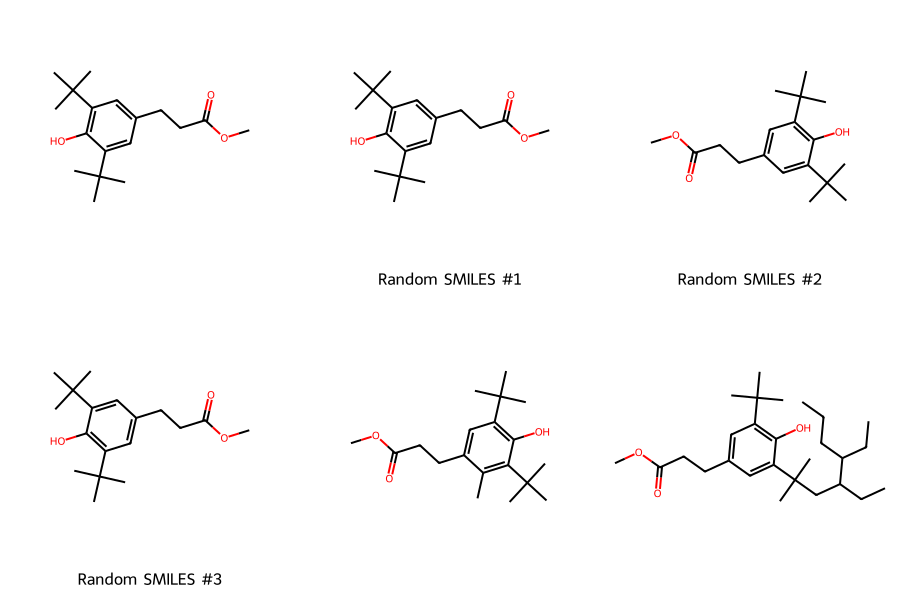


Исходная молекула: C(C(=O)OC)Cc1cc(C(C)(C)C)c(O)c(c1)C(C)(C)C
  Случайные SMILES (3 примера):
    1. c1c(c(O)c(cc1CCC(OC)=O)C(C)(C)C)C(C)(C)C
    2. c1(C(C)(C)C)c(O)c(C(C)(C)C)cc(c1)CCC(OC)=O
    3. CC(c1c(O)c(cc(c1)CCC(OC)=O)C(C)(C)C)(C)C
------------------------------------------------------------
Визуализация молекул:


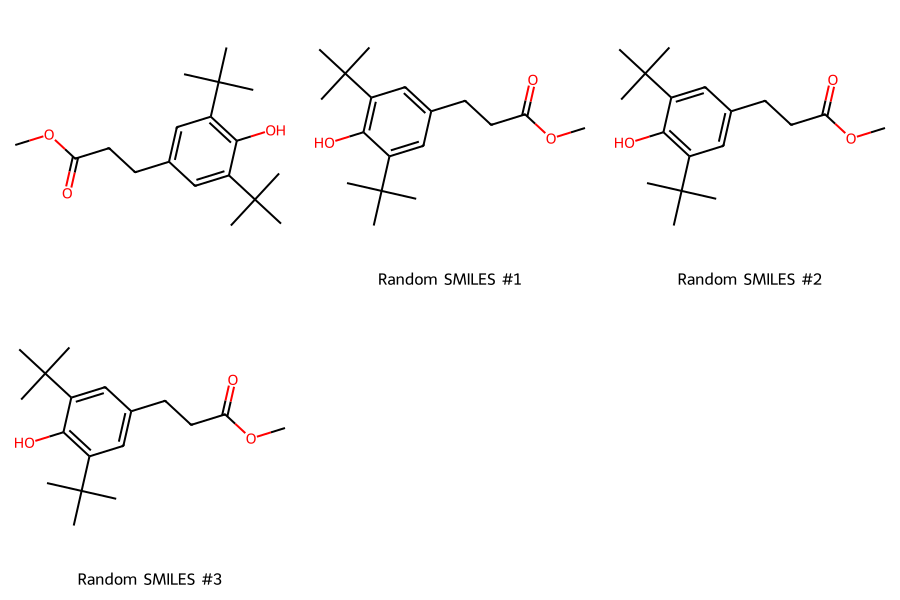

In [140]:
import pandas as pd
import random
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import display
import matplotlib.pyplot as plt
import io
import base64
from PIL import Image

# Предыдущие функции остаются без изменений...

def show_molecule_images(mol_smiles_list, labels=None, n_cols=3, mol_size=(300, 300)):
    """
    Показывает изображения молекул, заданных через SMILES.
    
    Args:
        mol_smiles_list (list): Список SMILES-строк молекул
        labels (list, optional): Список подписей для молекул
        n_cols (int): Количество колонок в сетке изображений
        mol_size (tuple): Размер одного изображения молекулы (ширина, высота)
    """
    mols = [Chem.MolFromSmiles(smiles) for smiles in mol_smiles_list if smiles]
    
    # Отфильтровать None, если какие-то SMILES некорректны
    mols = [mol for mol in mols if mol is not None]
    
    # Если нет подписей, используем SMILES
    if labels is None:
        labels = [Chem.MolToSmiles(mol) for mol in mols]
    else:
        # Обрезаем список подписей, чтобы он соответствовал количеству молекул
        labels = labels[:len(mols)]
    
    # Вычисляем количество строк в сетке
    n_rows = (len(mols) + n_cols - 1) // n_cols
    
    # Создаем сетку изображений
    img = Draw.MolsToGridImage(mols, molsPerRow=n_cols, subImgSize=mol_size, legends=labels)
    
    # Отображаем изображение
    display(img)
    
    return img

def show_augmentation_examples_with_images(df, smiles_col='SMILES'):
    """
    Выполняет аугментацию нескольких молекул и выводит примеры для каждого типа
    с визуализацией структур
    """
    # Берем первые 2 молекулы для примера
    sample_df = df.head(2)
    augmented = augment_molecules(sample_df, smiles_col)
    
    print(f"Примеры аугментации молекул:")
    print("=" * 60)
    
    for orig_smiles in sample_df[smiles_col]:
        print(f"Исходная молекула: {orig_smiles}")
        
        # Собираем SMILES и подписи для визуализации
        visualization_smiles = [orig_smiles]
        visualization_labels = ["Исходная молекула"]
        
        # Показываем примеры случайных SMILES
        rand_examples = augmented[(augmented['original_SMILES'] == orig_smiles) & 
                                 (augmented['augmentation_type'] == 'random_smiles')]
        if not rand_examples.empty:
            print("  Случайные SMILES (3 примера):")
            for i, example in enumerate(rand_examples[smiles_col].head(3)):
                print(f"    {i+1}. {example}")
                visualization_smiles.append(example)
                visualization_labels.append(f"Random SMILES #{i+1}")
        
        # Показываем пример метилирования (если есть)
        methyl_example = augmented[(augmented['original_SMILES'] == orig_smiles) & 
                                  (augmented['augmentation_type'] == 'methylation')]
        if not methyl_example.empty:
            methyl_smiles = methyl_example.iloc[0][smiles_col]
            print("  Метилированная версия:")
            print(f"    {methyl_smiles}")
            visualization_smiles.append(methyl_smiles)
            visualization_labels.append("Метилированная")
        
        # Показываем пример алкилирования (если есть)
        alkyl_example = augmented[(augmented['original_SMILES'] == orig_smiles) & 
                                 (augmented['augmentation_type'] == 'alkylation')]
        if not alkyl_example.empty:
            alkyl_smiles = alkyl_example.iloc[0][smiles_col]
            print("  Версия с алкильной цепью:")
            print(f"    {alkyl_smiles}")
            visualization_smiles.append(alkyl_smiles)
            visualization_labels.append("Алкилированная")
        
        print("-" * 60)
        print("Визуализация молекул:")
        
        # Визуализируем молекулы
        show_molecule_images(visualization_smiles, visualization_labels)
        
        print("\n" + "=" * 60)
    
    return augmented

# Пример использования функции для демонстрации с визуализацией

augmented_examples = show_augmentation_examples_with_images(df_augmented_train)

In [142]:
import pandas as pd
import numpy as np

# Загрузка данных уже выполнена, используем df_augmented_train и t

# Определение высоких и низких значений для обоих параметров
activity_median = df_augmented_train['NORM'].median()
norm_median = t['NORM'].median()

# Разделение молекул на высокие и низкие по метрикам
df_augmented_train['high_activity'] = df_augmented_train['NORM'] > activity_median
t['high_norm'] = t['NORM'] > norm_median

# Получаем список молекул с высоким и низким NORM из датасета t
high_norm_molecules = t[t['high_norm'] == True]
low_norm_molecules = t[t['high_norm'] == False]

# Создание триплетов
triplets = []

for _, anchor in df_augmented_train.iterrows():
    anchor_id = anchor['SMILES']  # Аугментированная молекула
    original_id = anchor['original_SMILES']  # Исходная молекула
    is_high_activity = anchor['high_activity']
    
    # Положительным примером будет исходная молекула
    positive = original_id
    
    # Логика отрицательного примера остается прежней
    if is_high_activity:
        # Для высокой активности якоря берем случайную молекулу с низким NORM
        negative = low_norm_molecules.sample(1).iloc[0]['SMILES']
    else:
        # Для низкой активности якоря берем случайную молекулу с высоким NORM
        negative = high_norm_molecules.sample(1).iloc[0]['SMILES']
    
    # Добавляем триплет (якорь, положительный, отрицательный)
    triplets.append((anchor_id, positive, negative))

# Запись триплетов в файл
with open('triplet_2.txt', 'w') as f:
    for anchor, positive, negative in triplets:
        f.write(f"{anchor.upper()} {positive} {negative}\n")

print(f"Создан файл triplet.txt с {len(triplets)} триплетами.")

# Дополнительно: создадим небольшую статистику о созданных триплетах
print(f"Количество уникальных якорных молекул: {len(set([t[0] for t in triplets]))}")
print(f"Количество уникальных положительных молекул: {len(set([t[1] for t in triplets]))}")
print(f"Количество уникальных отрицательных молекул: {len(set([t[2] for t in triplets]))}")

Создан файл triplet.txt с 288 триплетами.
Количество уникальных якорных молекул: 288
Количество уникальных положительных молекул: 13
Количество уникальных отрицательных молекул: 13


In [125]:
df_augmented_train['SMILES'].str.upper()

0       C1C(C(C(CC1CCC(OC)=O)C(C)(C)C)O)C(C)(C)C
0       C1(C(C)(C)C)CC(CC(C(C)(C)C)C1O)CCC(OC)=O
0     C1(CC(C(C)(C)C)C(O)C(C(C)(C)C)C1)CCC(OC)=O
0       C1C(CC(C(C)(C)C)C(C1C(C)(C)C)O)CCC(=O)OC
0         CC(C)(C1CC(CC(C1O)C(C)(C)C)CCC(=O)OC)C
                         ...                    
12                               C1C(CCC(O)C1)CC
12                               C1(CCC(CC)CC1)O
12                               C1(O)CCC(CC)CC1
12                               C(C)C1CCC(O)CC1
12                                 OC1CCC(CC1)CC
Name: SMILES, Length: 178, dtype: object

(array([726.,  18.,   0.,  15.,  14.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,  15.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         34.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([2.50000000e-03, 1.50024750e+01, 3.00024500e+01, 4.50024250e+01,
        6.00024000e+01, 7.50023750e+01, 9.00023500e+01, 1.05002325e+02,
        1.20002300e+02, 1.35002275e+02, 1.50002250e+02, 1.65002225e+02,
        1.80002200e+02, 1.95002175e+02, 2.10002150e+02, 2.25002125e+02,
        2.40002100e+02, 2.5500

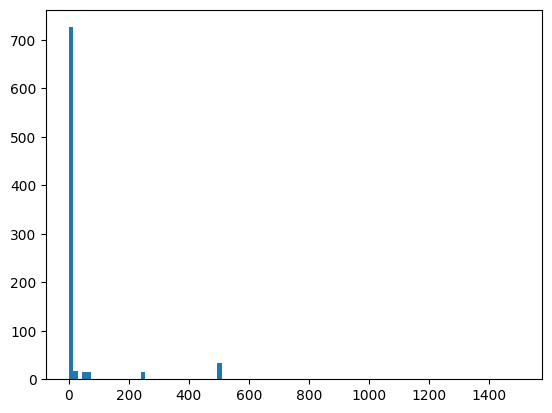

In [68]:
plt.hist(df['Activity_umolequiv_per_umol'], bins=100)

In [70]:
#PROPERTY_NAME = "drd2" # available only coma==0.1.5
# PROPERTY_NAME = "qed"
# PROPERTY_NAME = "logp04"
PROP_NAME_2 = 'activity'
PROPERTY_NAME = "logp04"
#PROPERTY_NAME = "logp06"

# 3.1 Create GP and toxicity prediction properties

In [17]:
example_test = pd.read_csv('/home/yagr/Hacathon/COMA/data/quantitive_neftekod25_data.csv')
example_test

,SMILES,C,PDSC
0,C1=CC=C(C=C1)NC2=CC=CC=C2,0.059689,1.600
1,C1=CC=C(C=C1)NC2=CC=CC=C2,0.120596,2.600
2,C1=CC=C(C=C1)NC2=CC=CC=C2,0.182759,5.000
3,C1=CC=C(C=C1)NC2=CC=CC=C2,0.246218,9.100
4,C1=CC=C(C=C1)NC2=CC=CC=C2,0.311012,14.000
5,C1=CC=C(C=C1)NC2=CC=CC=C2,0.656580,28.000
6,C1=CC=C(C=C1)NC2=CC=CC=C2,0.805803,36.000
7,C1=CC=C(C=C1)NC2=CC=CC=C2,1.042804,43.000
8,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.009077,10.930
9,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.021265,20.680


In [18]:
t

,SMILES,Predicted,NORM
0,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H],-12.330941,180.200563
1,C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC,10.883050,214.041839
2,C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32,12.483941,731.344892
3,C1=CC=C(C=C1)NC2=CC=CC=C2,1.392674,35.781639
4,CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C...,8.329837,992.272526
5,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,9.164125,1107.139265
6,CC1=C(C(=CC=C1)O)C,5.791605,15.911641
7,CC1=C(C=C(C=C1)O)C,8.672227,12.766451
8,CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C,5.791605,202.755677
9,CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C...,8.329837,1711.958720


In [146]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, MACCSkeys, Crippen
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.EState.EState import EStateIndices
from rdkit.Chem.rdMolDescriptors import CalcNumHBA, CalcNumHBD, CalcTPSA, CalcNumRotatableBonds, CalcNumRings
from rdkit.Chem.Lipinski import NumHAcceptors, NumHDonors
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.AllChem import ComputeGasteigerCharges
from sklearn.preprocessing import StandardScaler
from typing import List, Tuple, Dict, Any, Union, Optional
import warnings
warnings.filterwarnings('ignore')

class MolecularDescriptorGenerator:
    """Класс для генерации молекулярных дескрипторов из SMILES."""
    
    def __init__(self, morgan_radius: int = 2, morgan_nBits: int = 2048):
        """
        Инициализирует генератор дескрипторов.
        
        Args:
            morgan_radius: Радиус для Morgan fingerprints
            morgan_nBits: Количество битов для Morgan fingerprints
        """
        self.morgan_radius = morgan_radius
        self.morgan_nBits = morgan_nBits
        
    def smiles_to_mol(self, smiles: str) -> Optional[Chem.Mol]:
        """Преобразует SMILES в молекулу RDKit."""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Невозможно преобразовать SMILES: {smiles}")
            return None
        return mol
    
    def calculate_dipole_moment_gasteiger(self, mol: Chem.Mol) -> float:
        """
        Вычисление приближенного дипольного момента с использованием зарядов Gasteiger.
        
        Это приближенный метод, не требующий 3D-координат.
        """
        if mol is None:
            return 0.0
            
        # Добавляем заряды Gasteiger
        try:
            ComputeGasteigerCharges(mol)
            
            # Получаем заряды и координаты атомов
            charges = []
            for atom in mol.GetAtoms():
                charge = float(atom.GetProp('_GasteigerCharge'))
                charges.append(charge)
                
            # Как приближение, используем сумму абсолютных значений зарядов
            # Настоящий дипольный момент требует 3D-координат
            dipole_approximation = sum(abs(c) for c in charges)
            return dipole_approximation
        except:
            return 0.0
    
    def calculate_dipole_moment_mmff(self, mol: Chem.Mol) -> float:
        """
        Вычисление дипольного момента с использованием MMFF.
        
        Этот метод требует 3D-координат, которые генерируются.
        """
        if mol is None:
            return 0.0
            
        try:
            # Создаем 3D-координаты
            mol_3d = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3d, randomSeed=42)
            AllChem.MMFFOptimizeMolecule(mol_3d)
            
            # Вычисляем дипольный момент
            AllChem.ComputeGasteigerCharges(mol_3d)
            dipole = AllChem.CalcDipoleVec(mol_3d)
            dipole_moment = np.sqrt(dipole[0]**2 + dipole[1]**2 + dipole[2]**2)
            return dipole_moment
        except:
            return 0.0
    
    def generate_descriptors(self, smiles_list: List[str]) -> pd.DataFrame:
        """
        Генерирует молекулярные дескрипторы для списка SMILES.
        
        Args:
            smiles_list: Список SMILES
            
        Returns:
            DataFrame с молекулярными дескрипторами
        """
        data = []
        
        for smiles in smiles_list:
            mol = self.smiles_to_mol(smiles)
            
            if mol is None:
                continue
                
            # Словарь для хранения дескрипторов
            descriptors = {}
            
            # SMILES и молекулярный вес
            descriptors['SMILES'] = smiles
            descriptors['MolecularWeight'] = MolWt(mol)
            
            # Morgan fingerprints
            morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.morgan_radius, nBits=self.morgan_nBits)
            morgan_features = {f'Morgan_{i}': int(morgan_fp[i]) for i in range(self.morgan_nBits)}
            
            # MACCS keys
            maccs = MACCSkeys.GenMACCSKeys(mol)
            maccs_features = {f'MACCS_{i}': int(maccs[i]) for i in range(len(maccs))}
            
            # Дипольный момент (разными методами)
            descriptors['DipoleGasteiger'] = self.calculate_dipole_moment_gasteiger(mol)
            descriptors['DipoleMomentMMFF'] = self.calculate_dipole_moment_mmff(mol)
            
            # BertzCT
            descriptors['BertzCT'] = Descriptors.BertzCT(mol)
            
            # Добавляем дополнительные дескрипторы
            descriptors['LogP'] = Crippen.MolLogP(mol)
            descriptors['TPSA'] = CalcTPSA(mol)
            descriptors['NumHDonors'] = NumHDonors(mol)
            descriptors['NumHAcceptors'] = NumHAcceptors(mol)
            descriptors['NumRotatableBonds'] = CalcNumRotatableBonds(mol)
            descriptors['NumRings'] = CalcNumRings(mol)
            descriptors['NumAromaticRings'] = Chem.Lipinski.NumAromaticRings(mol)
            
            # Объединяем все дескрипторы
            all_descriptors = {**descriptors, **morgan_features, **maccs_features}
            data.append(all_descriptors)
        
        # Создаем датафрейм
        df = pd.DataFrame(data)
        return df
    
    def view_molecules(self, smiles_list: List[str], n: int = 10) -> None:
        """Визуализирует молекулы."""
        mols = [self.smiles_to_mol(s) for s in smiles_list[:n]]
        mols = [m for m in mols if m is not None]
        if mols:
            return MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200))


class FeatureSelector:
    """Класс для отбора признаков с использованием случайного леса."""
    
    def __init__(self, task_type: str = 'regression', n_estimators: int = 100, 
                 random_state: int = 42, threshold: str = 'median'):
        """
        Инициализирует селектор признаков.
        
        Args:
            task_type: Тип задачи ('regression' или 'classification')
            n_estimators: Количество деревьев в случайном лесу
            random_state: Зерно для генератора случайных чисел
            threshold: Порог для отбора признаков
        """
        self.task_type = task_type
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.threshold = threshold
        
        if task_type == 'regression':
            self.model = RandomForestRegressor(
                n_estimators=n_estimators, 
                random_state=random_state,
                n_jobs=-1
            )
        else:
            self.model = RandomForestClassifier(
                n_estimators=n_estimators, 
                random_state=random_state,
                n_jobs=-1
            )
        
        self.selector = None
        self.selected_features = None
        
    def fit(self, X: pd.DataFrame, y: np.ndarray) -> List[str]:
        """
        Обучает модель и выбирает наиболее важные признаки.
        
        Args:
            X: Датафрейм с признаками
            y: Целевая переменная
            
        Returns:
            Список выбранных признаков
        """
        # Обучаем модель
        self.model.fit(X, y)
        
        # Выбираем признаки
        self.selector = SelectFromModel(self.model, threshold=self.threshold, prefit=True)
        
        # Получаем маску выбранных признаков
        feature_mask = self.selector.get_support()
        
        # Получаем имена выбранных признаков
        self.selected_features = X.columns[feature_mask].tolist()
        
        return self.selected_features
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Преобразует датафрейм, оставляя только выбранные признаки.
        
        Args:
            X: Датафрейм с признаками
            
        Returns:
            Датафрейм с выбранными признаками
        """
        if self.selector is None:
            raise ValueError("Необходимо сначала вызвать метод fit.")
        
        X_selected = self.selector.transform(X)
        return pd.DataFrame(X_selected, columns=self.selected_features)
    
    def fit_transform(self, X: pd.DataFrame, y: np.ndarray) -> pd.DataFrame:
        """
        Обучает модель и преобразует датафрейм.
        
        Args:
            X: Датафрейм с признаками
            y: Целевая переменная
            
        Returns:
            Датафрейм с выбранными признаками
        """
        self.fit(X, y)
        return self.transform(X)
    
    def evaluate(self, X_train: pd.DataFrame, X_test: pd.DataFrame, 
                 y_train: np.ndarray, y_test: np.ndarray) -> Dict[str, float]:
        """
        Оценивает модель с выбранными признаками.
        
        Args:
            X_train: Обучающая выборка признаков
            X_test: Тестовая выборка признаков
            y_train: Обучающая выборка целевой переменной
            y_test: Тестовая выборка целевой переменной
            
        Returns:
            Словарь с метриками
        """
        # Преобразуем данные, оставляя только выбранные признаки
        X_train_selected = self.transform(X_train)
        X_test_selected = self.transform(X_test)
        
        # Обучаем новую модель на выбранных признаках
        if self.task_type == 'regression':
            model = RandomForestRegressor(
                n_estimators=self.n_estimators, 
                random_state=self.random_state,
                n_jobs=-1
            )
            model.fit(X_train_selected, y_train)
            y_pred = model.predict(X_test_selected)
            
            # Вычисляем метрики
            metrics = {
                'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
                'R2': r2_score(y_test, y_pred)
            }
        else:
            model = RandomForestClassifier(
                n_estimators=self.n_estimators, 
                random_state=self.random_state,
                n_jobs=-1
            )
            model.fit(X_train_selected, y_train)
            y_pred = model.predict(X_test_selected)
            
            # Вычисляем метрики
            precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
            metrics = {
                'Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            }
        
        return metrics
    
    def get_feature_importance(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        Возвращает важность признаков.
        
        Args:
            X: Датафрейм с признаками
            
        Returns:
            Датафрейм с важностью признаков
        """
        if not hasattr(self.model, 'feature_importances_'):
            raise ValueError("Модель не имеет атрибута feature_importances_.")
        
        # Получаем важность признаков
        importances = self.model.feature_importances_
        
        # Создаем датафрейм с важностью признаков
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        })
        
        # Сортируем по важности
        feature_importance = feature_importance.sort_values('Importance', ascending=False)
        
        return feature_importance
    
    def plot_feature_importance(self, X: pd.DataFrame, top_n: int = 20) -> None:
        """
        Визуализирует важность признаков.
        
        Args:
            X: Датафрейм с признаками
            top_n: Количество признаков для отображения
        """
        feature_importance = self.get_feature_importance(X)
        
        # Берем top_n признаков
        top_features = feature_importance.head(top_n)
        
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title(f'Top {top_n} Feature Importance')
        plt.tight_layout()
        plt.show()


def process_molecules_and_select_features(
    smiles_list: List[str], 
    target_values: List[Union[float, int]], 
    task_type: str = 'regression',
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[pd.DataFrame, List[str], Dict[str, float]]:
    """
    Основная функция для обработки молекул и отбора признаков.
    
    Args:
        smiles_list: Список SMILES
        target_values: Список целевых значений
        task_type: Тип задачи ('regression' или 'classification')
        test_size: Размер тестовой выборки
        random_state: Зерно для генератора случайных чисел
        
    Returns:
        Датафрейм с дескрипторами, список выбранных признаков, метрики модели
    """
    # Генерируем дескрипторы
    descriptor_generator = MolecularDescriptorGenerator()
    descriptors_df = descriptor_generator.generate_descriptors(smiles_list)
    
    # Визуализируем несколько молекул
    # descriptor_generator.view_molecules(smiles_list, n=5)
    
    # Удаляем столбец SMILES перед обучением модели
    X = descriptors_df.drop('SMILES', axis=1)
    y = np.array(target_values)
    
    # Разделяем данные на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Стандартизируем данные
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train), 
        columns=X_train.columns
    )
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test), 
        columns=X_test.columns
    )
    
    # Отбираем признаки
    feature_selector = FeatureSelector(task_type=task_type)
    selected_features = feature_selector.fit(X_train_scaled, y_train)
    
    # Оцениваем модель с отобранными признаками
    metrics = feature_selector.evaluate(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Визуализируем важность признаков
    # feature_selector.plot_feature_importance(X_train_scaled, top_n=20)
    
    return descriptors_df, selected_features, metrics


# Пример использования
if __name__ == "__main__":
    # Пример списка SMILES
    smiles_list = t['SMILES']
    
    # Пример целевых значений (логарифм растворимости в воде)
    # Это пример значений, в реальности нужно использовать настоящие экспериментальные данные
    target_values = np.log(t['NORM'])
    
    # Обрабатываем молекулы и отбираем признаки
    descriptors_df, selected_features, metrics = process_molecules_and_select_features(
        smiles_list, target_values
    )
    
    # Выводим результаты
    print("Количество сгенерированных дескрипторов:", len(descriptors_df.columns) - 1)  # -1 for SMILES
    print("\nОтобранные признаки:")
    for feature in selected_features:
        print(f"- {feature}")
    
    print("\nМетрики модели с отобранными признаками:")
    for metric, value in metrics.items():
        print(f"- {metric}: {value:.4f}")

Количество сгенерированных дескрипторов: 2226

Отобранные признаки:
- MolecularWeight
- DipoleGasteiger
- DipoleMomentMMFF
- BertzCT
- LogP
- TPSA
- NumHDonors
- NumHAcceptors
- NumRotatableBonds
- NumRings
- NumAromaticRings
- Morgan_0
- Morgan_1
- Morgan_2
- Morgan_3
- Morgan_4
- Morgan_5
- Morgan_6
- Morgan_7
- Morgan_8
- Morgan_9
- Morgan_10
- Morgan_11
- Morgan_12
- Morgan_13
- Morgan_14
- Morgan_15
- Morgan_16
- Morgan_17
- Morgan_18
- Morgan_19
- Morgan_20
- Morgan_21
- Morgan_22
- Morgan_23
- Morgan_24
- Morgan_25
- Morgan_26
- Morgan_27
- Morgan_28
- Morgan_29
- Morgan_30
- Morgan_31
- Morgan_32
- Morgan_33
- Morgan_34
- Morgan_35
- Morgan_36
- Morgan_37
- Morgan_38
- Morgan_39
- Morgan_40
- Morgan_41
- Morgan_42
- Morgan_43
- Morgan_44
- Morgan_45
- Morgan_46
- Morgan_47
- Morgan_48
- Morgan_49
- Morgan_50
- Morgan_51
- Morgan_52
- Morgan_53
- Morgan_54
- Morgan_55
- Morgan_56
- Morgan_57
- Morgan_58
- Morgan_59
- Morgan_60
- Morgan_61
- Morgan_62
- Morgan_63
- Morgan_64
- Mo

# 3.2 Create GaussModel

In [19]:
example_test

,SMILES,C,PDSC
0,C1=CC=C(C=C1)NC2=CC=CC=C2,0.059689,1.600
1,C1=CC=C(C=C1)NC2=CC=CC=C2,0.120596,2.600
2,C1=CC=C(C=C1)NC2=CC=CC=C2,0.182759,5.000
3,C1=CC=C(C=C1)NC2=CC=CC=C2,0.246218,9.100
4,C1=CC=C(C=C1)NC2=CC=CC=C2,0.311012,14.000
5,C1=CC=C(C=C1)NC2=CC=CC=C2,0.656580,28.000
6,C1=CC=C(C=C1)NC2=CC=CC=C2,0.805803,36.000
7,C1=CC=C(C=C1)NC2=CC=CC=C2,1.042804,43.000
8,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.009077,10.930
9,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.021265,20.680


In [20]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Crippen
from rdkit.Chem.Descriptors import MolWt
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcNumRotatableBonds, CalcNumRings
from rdkit.Chem.Lipinski import NumHAcceptors, NumHDonors
from typing import Union, Optional
import warnings
warnings.filterwarnings('ignore')

def add_molecular_descriptors(df: pd.DataFrame, smiles_column: str = 'SMILES') -> pd.DataFrame:
    """
    Функция, которая добавляет молекулярные дескрипторы к датафрейму на основе SMILES.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Исходный датафрейм, который должен содержать колонку с SMILES.
    smiles_column : str, default='SMILES'
        Название колонки, содержащей SMILES строки.
        
    Returns:
    --------
    pd.DataFrame
        Датафрейм с добавленными молекулярными дескрипторами.
    
    Добавляемые дескрипторы:
    - MolecularWeight: молекулярная масса
    - DipoleGasteiger: дипольный момент на основе зарядов Gasteiger
    - DipoleMomentMMFF: дипольный момент с использованием MMFF
    - BertzCT: индекс комплексности молекулы
    - LogP: коэффициент распределения октанол-вода
    - TPSA: топологическая полярная площадь поверхности
    - NumHDonors: количество доноров водородных связей
    - NumHAcceptors: количество акцепторов водородных связей
    - NumRotatableBonds: количество вращающихся связей
    - NumRings: количество колец
    - NumAromaticRings: количество ароматических колец
    """
    
    # Проверяем наличие колонки SMILES в датафрейме
    if smiles_column not in df.columns:
        raise ValueError(f"Колонка '{smiles_column}' не найдена в датафрейме")
    
    # Создаем копию датафрейма, чтобы не изменять оригинал
    result_df = df.copy()
    
    # Функция для вычисления дипольного момента с использованием зарядов Gasteiger
    def calculate_dipole_moment_gasteiger(mol: Optional[Chem.Mol]) -> float:
        """Вычисляет приближенный дипольный момент с использованием зарядов Gasteiger."""
        if mol is None:
            return np.nan
        
        try:
            # Добавляем заряды Gasteiger
            AllChem.ComputeGasteigerCharges(mol)
            
            # Получаем заряды атомов
            charges = []
            for atom in mol.GetAtoms():
                charge = float(atom.GetProp('_GasteigerCharge'))
                charges.append(charge)
            
            # Используем сумму абсолютных значений зарядов как приближение
            dipole_approximation = sum(abs(c) for c in charges)
            return dipole_approximation
        except:
            return np.nan
    
    # Функция для вычисления дипольного момента с использованием MMFF
    def calculate_dipole_moment_mmff(mol: Optional[Chem.Mol]) -> float:
        """Вычисляет дипольный момент с использованием MMFF (требует 3D координат)."""
        if mol is None:
            return np.nan
        
        try:
            # Создаем копию молекулы, добавляем водороды и генерируем 3D координаты
            mol_3d = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_3d, randomSeed=42)
            
            # Оптимизируем геометрию с использованием MMFF
            try:
                AllChem.MMFFOptimizeMolecule(mol_3d)
            except:
                # Если MMFF не сработал, пробуем UFF
                try:
                    AllChem.UFFOptimizeMolecule(mol_3d)
                except:
                    # Если и UFF не сработал, оставляем как есть
                    pass
            
            # Вычисляем дипольный момент
            try:
                dipole = AllChem.CalcDipoleVec(mol_3d)
                dipole_moment = np.sqrt(dipole[0]**2 + dipole[1]**2 + dipole[2]**2)
                return dipole_moment
            except:
                return np.nan
        except:
            return np.nan
    
    # Функция для преобразования SMILES в молекулу RDKit
    def smiles_to_mol(smiles: str) -> Optional[Chem.Mol]:
        """Преобразует SMILES в молекулу RDKit."""
        try:
            mol = Chem.MolFromSmiles(smiles)
            return mol
        except:
            return None
    
    # Функция для вычисления всех дескрипторов для одной молекулы
    def calculate_descriptors(smiles: str) -> dict:
        """Вычисляет все дескрипторы для одной молекулы."""
        mol = smiles_to_mol(smiles)
        
        if mol is None:
            return {
                'MolecularWeight': np.nan,
                'DipoleGasteiger': np.nan,
                'DipoleMomentMMFF': np.nan,
                'BertzCT': np.nan,
                'LogP': np.nan,
                'TPSA': np.nan,
                'NumHDonors': np.nan,
                'NumHAcceptors': np.nan,
                'NumRotatableBonds': np.nan,
                'NumRings': np.nan,
                'NumAromaticRings': np.nan
            }
        
        # Вычисляем дескрипторы
        descriptors = {
            'MolecularWeight': MolWt(mol),
            'DipoleGasteiger': calculate_dipole_moment_gasteiger(mol),
            'DipoleMomentMMFF': calculate_dipole_moment_mmff(mol),
            'BertzCT': Descriptors.BertzCT(mol),
            'LogP': Crippen.MolLogP(mol),
            'TPSA': CalcTPSA(mol),
            'NumHDonors': NumHDonors(mol),
            'NumHAcceptors': NumHAcceptors(mol),
            'NumRotatableBonds': CalcNumRotatableBonds(mol),
            'NumRings': CalcNumRings(mol),
            'NumAromaticRings': Chem.Lipinski.NumAromaticRings(mol)
        }
        
        return descriptors
    
    # Применяем функцию вычисления дескрипторов к каждой SMILES строке
    descriptors_list = []
    total_rows = len(result_df)
    
    for i, smiles in enumerate(result_df[smiles_column]):
        # Для отслеживания прогресса (каждые 10%)
        if i % max(1, total_rows // 10) == 0:
            print(f"Обработано {i}/{total_rows} молекул ({i/total_rows*100:.1f}%)")
        
        descriptors = calculate_descriptors(smiles)
        descriptors_list.append(descriptors)
    
    # Создаем датафрейм с дескрипторами
    descriptors_df = pd.DataFrame(descriptors_list)
    
    # Объединяем исходный датафрейм с дескрипторами
    result_df = pd.concat([result_df, descriptors_df], axis=1)
    
    print(f"Обработка завершена. Добавлено {len(descriptors_df.columns)} молекулярных дескрипторов.")
    
    return result_df


# Пример использования
if __name__ == "__main__":
    # Создаем тестовый датафрейм
    
    # Добавляем молекулярные дескрипторы
    result_df = add_molecular_descriptors(example_test)
    
    # Выводим результаты
    print("\nПервые 2 строки результирующего датафрейма:")
    print(result_df.head(2))
    
    # Выводим статистику по дескрипторам
    print("\nСтатистика по дескрипторам:")
    descriptors_columns = ['MolecularWeight', 'DipoleGasteiger', 'DipoleMomentMMFF', 'BertzCT', 
                          'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 
                          'NumRings', 'NumAromaticRings']
    print(result_df[descriptors_columns].describe())

Обработано 0/55 молекул (0.0%)
Обработано 5/55 молекул (9.1%)
Обработано 10/55 молекул (18.2%)
Обработано 15/55 молекул (27.3%)
Обработано 20/55 молекул (36.4%)
Обработано 25/55 молекул (45.5%)
Обработано 30/55 молекул (54.5%)
Обработано 35/55 молекул (63.6%)
Обработано 40/55 молекул (72.7%)
Обработано 45/55 молекул (81.8%)
Обработано 50/55 молекул (90.9%)
Обработка завершена. Добавлено 11 молекулярных дескрипторов.

Первые 2 строки результирующего датафрейма:
                      SMILES         C  PDSC  MolecularWeight  \
0  C1=CC=C(C=C1)NC2=CC=CC=C2  0.059689   1.6          169.227   
1  C1=CC=C(C=C1)NC2=CC=CC=C2  0.120596   2.6          169.227   

   DipoleGasteiger  DipoleMomentMMFF     BertzCT    LogP   TPSA  NumHDonors  \
0         0.951785               NaN  315.898649  3.4302  12.03           1   
1         0.951785               NaN  315.898649  3.4302  12.03           1   

   NumHAcceptors  NumRotatableBonds  NumRings  NumAromaticRings  
0              1                  2

In [183]:
te = pd.read_csv('/home/yagr/Hacathon/COMA/scripts/submit_1_results.csv', index_col=[0]).drop(['ID', 'Submit datetime'], axis=1)
te['C'] =[0.05 for i in range(len(te))]
te_ = te.drop(['PDSC'], axis=1)
te_

,SMILES,valid,stable,mass,atoms,soluble,C
0,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=C...,1,1,1,1,1,0.05
1,CC(C)(C)CCC(C)(C)C1=CC=CC=C1NC1=CC=CC2=CC=CC=C21,1,1,1,1,1,0.05
2,CC(C)(C)CCC(C)(C)C1=CC=CC=C1C1=CC=CC=C1NC1=CC=...,1,1,1,1,1,0.05
3,CC(C)(C)CCC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=...,1,1,1,1,1,0.05
4,C1=CC=CC=C1C1=CC=CC=C1NC1=CC=CC=C1CCCCCCCCCCCC...,1,1,1,1,1,0.05
5,CSC1=CC=CC=C1NC1=CC=CC=C1CCCCCCCCCCCCCCCCCCCCC...,1,1,1,1,1,0.05
6,CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=...,1,1,1,1,1,0.05
7,CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=...,1,1,1,1,1,0.05
8,CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=...,1,1,1,1,1,0.05
9,CSC1=CC(C(=O)C2CCCC2)=CC=C1C1=CC=CC=C1CCCCC1=C...,1,1,1,1,1,0.05


In [186]:
result_df_ = add_molecular_descriptors(te_)

# Выводим результаты
print("\nПервые 2 строки результирующего датафрейма:")
print(result_df_.head(2))

# Выводим статистику по дескрипторам
print("\nСтатистика по дескрипторам:")
descriptors_columns = ['MolecularWeight', 'DipoleGasteiger', 'DipoleMomentMMFF', 'BertzCT', 
                        'LogP', 'TPSA', 'NumHDonors', 'NumHAcceptors', 'NumRotatableBonds', 
                        'NumRings', 'NumAromaticRings']
print(result_df_[descriptors_columns].describe())

Обработано 0/21 молекул (0.0%)
Обработано 2/21 молекул (9.5%)
Обработано 4/21 молекул (19.0%)
Обработано 6/21 молекул (28.6%)
Обработано 8/21 молекул (38.1%)
Обработано 10/21 молекул (47.6%)
Обработано 12/21 молекул (57.1%)
Обработано 14/21 молекул (66.7%)
Обработано 16/21 молекул (76.2%)
Обработано 18/21 молекул (85.7%)
Обработано 20/21 молекул (95.2%)
Обработка завершена. Добавлено 11 молекулярных дескрипторов.

Первые 2 строки результирующего датафрейма:
                                              SMILES  valid  stable  mass  \
0  CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=C...      1       1     1   
1   CC(C)(C)CCC(C)(C)C1=CC=CC=C1NC1=CC=CC2=CC=CC=C21      1       1     1   

   atoms  soluble     C  MolecularWeight  DipoleGasteiger  DipoleMomentMMFF  \
0      1        1  0.05          407.601         1.709789               NaN   
1      1        1  0.05          345.530         1.511422               NaN   

       BertzCT    LogP   TPSA  NumHDonors  NumHAcceptors  NumRotatab

In [21]:
result_df

,SMILES,C,PDSC,MolecularWeight,DipoleGasteiger,DipoleMomentMMFF,BertzCT,LogP,TPSA,NumHDonors,NumHAcceptors,NumRotatableBonds,NumRings,NumAromaticRings
0,C1=CC=C(C=C1)NC2=CC=CC=C2,0.059689,1.600,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
1,C1=CC=C(C=C1)NC2=CC=CC=C2,0.120596,2.600,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
2,C1=CC=C(C=C1)NC2=CC=CC=C2,0.182759,5.000,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
3,C1=CC=C(C=C1)NC2=CC=CC=C2,0.246218,9.100,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
4,C1=CC=C(C=C1)NC2=CC=CC=C2,0.311012,14.000,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
5,C1=CC=C(C=C1)NC2=CC=CC=C2,0.656580,28.000,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
6,C1=CC=C(C=C1)NC2=CC=CC=C2,0.805803,36.000,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
7,C1=CC=C(C=C1)NC2=CC=CC=C2,1.042804,43.000,169.227,0.951785,NaN,315.898649,3.43020,12.03,1,1,2,2,2
8,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.009077,10.930,331.503,1.458023,NaN,863.148053,7.29720,12.03,1,1,4,3,3
9,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.021265,20.680,331.503,1.458023,NaN,863.148053,7.29720,12.03,1,1,4,3,3


In [ ]:
from sklearn.preprocessing import StandardScaler
set(result_df.SMILES.unique())
X_train, X_test, y_train, y_test = train_test_split(result_df.drop(['SMILES','PDSC', 'DipoleMomentMMFF'], axis=1), result_df['PDSC'], test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [55]:
set(result_df.SMILES.unique())

{'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]',
 'C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC',
 'C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32',
 'C1=CC=C(C=C1)NC2=CC=CC=C2',
 'CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C',
 'CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32',
 'CC1=C(C(=CC=C1)O)C',
 'CC1=C(C=C(C=C1)O)C',
 'CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C',
 'CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O',
 'CC1=CC(=C(C=C1)C)O',
 'CC1=CC(=CC(=C1)O)C',
 'CCC1=CC=C(C=C1)O'}

In [30]:
import torch
import gpytorch
from gpytorch.models import ExactGP
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D



def create_gaussian_model(points, values=None):
    """
    Создает гауссову модель на базе точек
    
    Параметры:
    points: torch.Tensor - точки для обучения
    values: torch.Tensor - значения в этих точках (опционально)
    
    Возвращает:
    model: обученная модель
    likelihood: функция правдоподобия
    """
    # Если значения не предоставлены, генерируем случайные значения
    if values is None:
        values = torch.ones(len(points))
    
    # Убеждаемся, что данные имеют правильную форму и тип
    if not isinstance(points, torch.Tensor):
        points = torch.tensor(points, dtype=torch.float32)
    if not isinstance(values, torch.Tensor):
        values = torch.tensor(values, dtype=torch.float32)
    
    # Сохраняем копию входных данных, которую будем использовать для обучения
    train_x = points.clone()
    train_y = values.clone()
    
    
    # Создаем модель
    class ExactGPModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

        def forward(self, x):
            mean_x = self.mean_module(x)
            covar_x = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    # initialize likelihood and model
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = ExactGPModel(train_x, train_y, likelihood)
        
    # Переводим модель в режим обучения
    model.train()
    likelihood.train()
    
    # Оптимизатор
    optimizer = torch.optim.Adam([
        {'params': model.parameters()},
    ], lr=3e-4)
    
    # Функция потерь - отрицательное правдоподобие
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Обучение
    training_iterations = 500
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)  # Важно использовать train_x, а не points
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
    # Переводим модель в режим оценки
    model.eval()
    likelihood.eval()


def predict(model, likelihood, test_point):
    """
    Делает предсказание для заданной точки
    
    Параметры:
    model: обученная модель
    likelihood: функция правдоподобия
    test_point: torch.Tensor размера (1, 2) - тестовая точка
    
    Возвращает:
    mean: среднее предсказание
    lower, upper: границы доверительного интервала
    """
    model.eval()
    likelihood.eval()
    
    with torch.no_grad():
        observed_pred = likelihood(model(test_point))
        mean = observed_pred.mean
        lower, upper = observed_pred.confidence_region()
    
    return mean, lower, upper


def visualize_model(model, likelihood, points, grid_size=50):
    """
    Визуализирует модель на двумерной сетке
    
    Параметры:
    model: обученная модель
    likelihood: функция правдоподобия
    points: torch.Tensor размера (4, 2) - 4 двумерные точки
    grid_size: размер сетки для визуализации
    """
    # Создаем сетку для визуализации
    x_min, x_max = points[:, 0].min().item() - 1, points[:, 0].max().item() + 1
    y_min, y_max = points[:, 1].min().item() - 1, points[:, 1].max().item() + 1
    
    x = np.linspace(x_min, x_max, grid_size)
    y = np.linspace(y_min, y_max, grid_size)
    x_grid, y_grid = np.meshgrid(x, y)
    
    # Преобразуем сетку в тензор
    grid = torch.tensor(np.vstack([x_grid.flatten(), y_grid.flatten()]).T, dtype=torch.float32)
    
    # Получаем предсказания на сетке
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        predictions = likelihood(model(grid))
        mean = predictions.mean.numpy().reshape(grid_size, grid_size)
        
    # Создаем 3D график
    fig = plt.figure(figsize=(12, 6))
    
    # 3D поверхность
    ax1 = fig.add_subplot(121, projection='3d')
    surf = ax1.plot_surface(x_grid, y_grid, mean, cmap=cm.viridis, linewidth=0, antialiased=False)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Value')
    ax1.set_title('3D поверхность гауссовой модели')
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=5)
    
    # Контурный график
    ax2 = fig.add_subplot(122)
    contour = ax2.contourf(x_grid, y_grid, mean, levels=20, cmap=cm.viridis)
    ax2.scatter(points[:, 0], points[:, 1], c='red', s=50, marker='o', label='Опорные точки')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Контурный график гауссовой модели')
    fig.colorbar(contour, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    return mean

In [167]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
set(result_df.SMILES.unique())
X_train, X_test, y_train, y_test = train_test_split(result_df.drop(['SMILES','PDSC', 'DipoleMomentMMFF'], axis=1), np.log(result_df['PDSC']), test_size=0.2, random_state=42)
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model

# Преобразование данных в тензоры
train_x = torch.tensor(X_train, dtype=torch.float32).to(device)
train_y = torch.tensor(np.array(y_train).flatten(), dtype=torch.float32).to(device)  # 1D тензор

# Инициализация модели
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(torch.from_numpy(X_train), torch.from_numpy(np.array(y_train)), likelihood).to(device)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Обучение
model.train()
for i in tqdm(range(500)):
    optimizer.zero_grad()
    output = model(torch.from_numpy(X_train).to(device))  # Используем исходный train_x
    loss = -mll(output, torch.from_numpy(np.array(y_train)).to(device))
    loss.backward()
    optimizer.step()

100%|██████████| 500/500 [00:00<00:00, 611.82it/s]


In [191]:
te_f = result_df_.drop(['DipoleMomentMMFF','valid','stable','mass','atoms','soluble', 'SMILES'], axis=1)

In [192]:
# te_f = result_df_.drop(['DipoleMomentMMFF'], axis=1)
te_f= scaler.transform(te_f)
te_f

array([[-0.60401722,  1.37144689,  0.38656841,  2.97930958,  1.63519436,
        -0.88216009, -0.50709255, -0.62812062,  0.34838222,  3.04800305,
         3.04800305],
       [-0.60401722,  0.77310424,  0.02206953,  1.60783133,  1.0957813 ,
        -0.88216009, -0.50709255, -0.62812062,  0.34838222,  1.65100165,
         1.65100165],
       [-0.60401722,  1.50666225,  0.51779447,  3.05054185,  1.79998802,
        -0.88216009, -0.50709255, -0.62812062,  0.55836602,  3.04800305,
         3.04800305],
       [-0.60401722,  3.7073363 ,  1.8654324 ,  7.71051262,  3.91260819,
        -0.88216009, -0.50709255, -0.62812062,  1.18831742,  7.23900724,
         7.23900724],
       [-0.60401722,  3.16811361,  1.81194179,  2.73849996,  3.80378777,
        -0.88216009, -0.50709255, -0.62812062,  3.91810685,  3.04800305,
         1.65100165],
       [-0.60401722,  6.97257463,  4.33247143,  7.23043967,  7.73518761,
        -0.88216009, -0.50709255,  0.82647451,  7.48783147,  5.84200584,
         4.445

In [198]:
te['PDSC']

0      59.232957
1      38.897173
2      63.691506
3     138.181376
4      20.719982
5       4.632566
6     225.020755
7     198.965929
8     173.397424
9      10.730643
10    104.755361
11      4.753128
12    100.362894
13      5.391959
14    257.693303
15     66.788296
16     76.441640
17     89.850521
18     90.814873
19     75.148476
20      4.933574
Name: PDSC, dtype: float64

In [199]:
mean, lower, upper = predict(model,likelihood, torch.from_numpy(te_f).to(device))
y_t = np.log(te['PDSC'])

In [ ]:
mean, lower, upper = predict(model,likelihood, torch.from_numpy(X_test).to(device))

LinearRegression()

In [206]:
i = 5
print((mean[i], np.array(y_t)[i]))
print((lower[i], np.array(y_t)[i]))
print((upper[i], np.array(y_t)[i]))

(tensor(0.1439, device='cuda:0', dtype=torch.float64), 1.5331109531386913)
(tensor(-2.3245, device='cuda:0', dtype=torch.float64), 1.5331109531386913)
(tensor(2.6122, device='cuda:0', dtype=torch.float64), 1.5331109531386913)


Используется устройство: cuda
Используется устройство: cuda
Подготовка данных...
Всего уникальных молекул: 13
Тренировочная выборка: 9 уникальных молекул, 32 строк
Валидационная выборка: 2 уникальных молекул, 12 строк
Тестовая выборка: 2 уникальных молекул, 11 строк

Обучение модели...


  0%|          | 0/10000 [00:00<?, ?it/s]

Train Loss: 1.0095, Val Loss: 1.0143, Val RMSE: 1.1044, Val R²: -0.0091: 100%|██████████| 10000/10000 [01:11<00:00, 140.64it/s]


Обучение завершено. Наилучшая модель на эпохе 8274
Наилучшая валидационная потеря: 0.9455
Финальный валидационный RMSE: 1.1228
Финальный валидационный R²: -0.0430


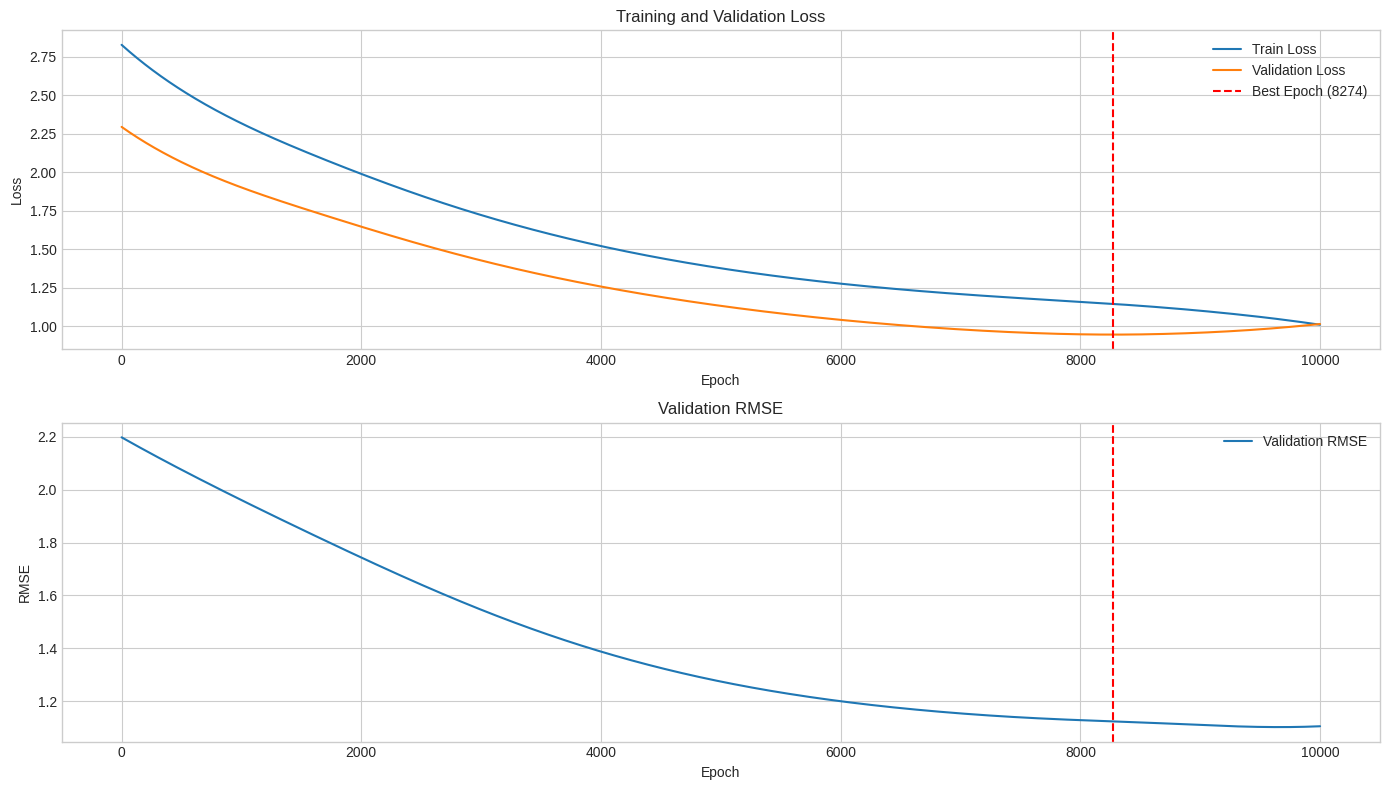


Оценка модели на тестовых данных...
Тестовый RMSE: 0.6606
Тестовый MAE: 0.5835
Тестовый R²: -0.6304
Средняя ширина доверительного интервала: 5.9350


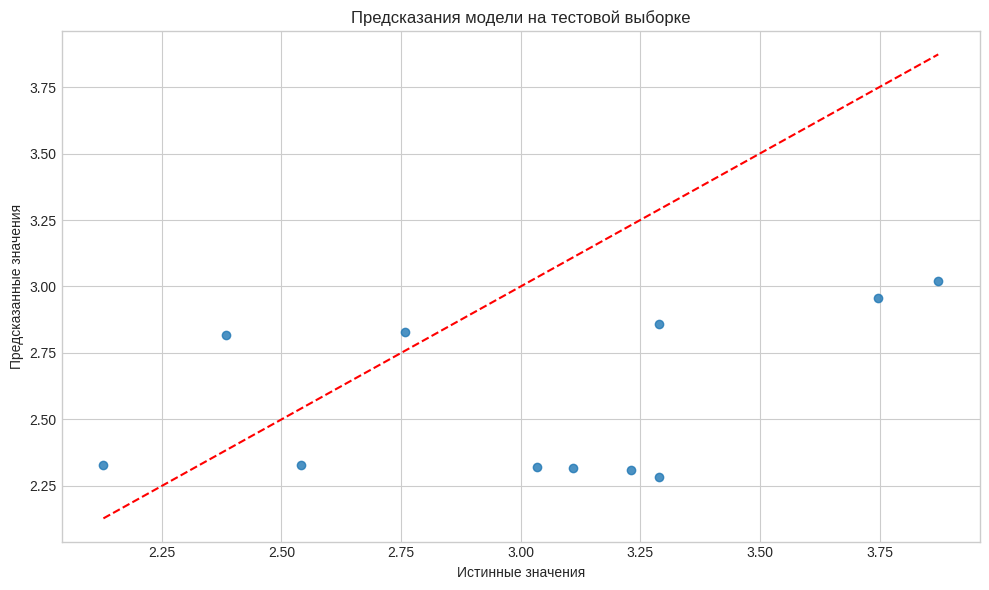

In [91]:
import torch
import gpytorch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Проверяем доступность GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

def split_by_molecules(df, test_molecules=2, validation_molecules=2, random_state=42):
    """
    Разделяет датафрейм так, чтобы определенное количество уникальных молекул
    попало в тестовую и валидационную выборки.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Датафрейм с данными, должен содержать колонку 'SMILES'
    test_molecules : int
        Количество уникальных молекул для тестовой выборки
    validation_molecules : int
        Количество уникальных молекул для валидационной выборки
    random_state : int
        Зерно для воспроизводимости результатов
        
    Returns:
    --------
    dict
        Словарь с индексами для тренировочной, валидационной и тестовой выборок
    """
    # Получаем уникальные SMILES
    unique_smiles = df['SMILES'].unique()
    n_unique = len(unique_smiles)
    
    if test_molecules + validation_molecules >= n_unique:
        raise ValueError(f"Сумма test_molecules и validation_molecules ({test_molecules + validation_molecules}) "
                         f"должна быть меньше количества уникальных молекул ({n_unique})")
    
    # Устанавливаем seed для воспроизводимости
    random.seed(random_state)
    np.random.seed(random_state)
    
    # Перемешиваем SMILES и выбираем для тестовой и валидационной выборок
    shuffled_smiles = np.random.permutation(unique_smiles)
    test_smiles = shuffled_smiles[:test_molecules]
    val_smiles = shuffled_smiles[test_molecules:test_molecules+validation_molecules]
    train_smiles = shuffled_smiles[test_molecules+validation_molecules:]
    
    # Создаем маски для индексов
    test_idx = df['SMILES'].isin(test_smiles)
    val_idx = df['SMILES'].isin(val_smiles)
    train_idx = df['SMILES'].isin(train_smiles)
    
    # Выводим информацию о разделении
    print(f"Всего уникальных молекул: {n_unique}")
    print(f"Тренировочная выборка: {len(train_smiles)} уникальных молекул, {train_idx.sum()} строк")
    print(f"Валидационная выборка: {len(val_smiles)} уникальных молекул, {val_idx.sum()} строк")
    print(f"Тестовая выборка: {len(test_smiles)} уникальных молекул, {test_idx.sum()} строк")
    
    return {
        'train_idx': train_idx,
        'val_idx': val_idx,
        'test_idx': test_idx,
        'train_smiles': train_smiles,
        'val_smiles': val_smiles,
        'test_smiles': test_smiles
    }

def prepare_data_for_gp(result_df, excluded_columns=['SMILES', 'PDSC', 'DipoleMomentMMFF'], 
                        target_column='PDSC', test_molecules=2, validation_molecules=2, 
                        random_state=42):
    """
    Подготавливает данные для гауссовского процесса, разделяя их по молекулам
    и выполняя нормализацию.
    
    Parameters:
    -----------
    result_df : pd.DataFrame
        Исходный датафрейм с данными
    excluded_columns : list
        Список колонок, которые нужно исключить из признаков
    target_column : str
        Имя колонки с целевой переменной
    test_molecules : int
        Количество уникальных молекул для тестовой выборки
    validation_molecules : int
        Количество уникальных молекул для валидационной выборки
    random_state : int
        Зерно для воспроизводимости результатов
        
    Returns:
    --------
    dict
        Словарь с подготовленными данными и информацией о разделении
    """
    # Проверяем наличие необходимых колонок
    if 'SMILES' not in result_df.columns:
        raise ValueError("Датафрейм должен содержать колонку 'SMILES'")
    if target_column not in result_df.columns:
        raise ValueError(f"Датафрейм должен содержать колонку '{target_column}'")
    
    # Разделяем данные по молекулам
    split_info = split_by_molecules(result_df, test_molecules, validation_molecules, random_state)
    
    # Получаем индексы для разных выборок
    train_idx = split_info['train_idx']
    val_idx = split_info['val_idx']
    test_idx = split_info['test_idx']
    
    # Исключаем указанные колонки из признаков
    feature_columns = [col for col in result_df.columns if col not in excluded_columns]
    
    # Разделяем данные на признаки и целевую переменную
    X_train = result_df.loc[train_idx, feature_columns].values
    y_train = np.log(result_df.loc[train_idx, target_column].values)
    
    shuffle_train=True

    if shuffle_train:
        train_indices = np.arange(len(X_train))
        np.random.seed(random_state)
        np.random.shuffle(train_indices)
        X_train = X_train[train_indices]
        y_train = y_train[train_indices]

    X_val = result_df.loc[val_idx, feature_columns].values
    y_val = np.log(result_df.loc[val_idx, target_column].values)
    
    X_test = result_df.loc[test_idx, feature_columns].values
    y_test = np.log(result_df.loc[test_idx, target_column].values)
    
    # Нормализуем данные
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Сохраняем информацию о признаках
    feature_info = {
        'feature_columns': feature_columns,
        'scaler': scaler
    }
    
    # Преобразуем данные в тензоры PyTorch
    train_x = torch.tensor(X_train_scaled, dtype=torch.float32)
    train_y = torch.tensor(y_train, dtype=torch.float32)
    
    val_x = torch.tensor(X_val_scaled, dtype=torch.float32)
    val_y = torch.tensor(y_val, dtype=torch.float32)
    
    test_x = torch.tensor(X_test_scaled, dtype=torch.float32)
    test_y = torch.tensor(y_test, dtype=torch.float32)
    
    # Возвращаем подготовленные данные и дополнительную информацию
    return {
        'train_x': train_x,
        'train_y': train_y,
        'val_x': val_x,
        'val_y': val_y,
        'test_x': test_x,
        'test_y': test_y,
        'feature_info': feature_info,
        'split_info': split_info
    }

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

def train_gp_model(train_x, train_y, val_x, val_y, num_epochs=500, lr=3e-4, patience=20, 
                   device='cpu', verbose=True, plot_losses=True):
    """
    Обучает модель гауссовского процесса с отслеживанием валидации.
    
    Parameters:
    -----------
    train_x, train_y : torch.Tensor
        Тренировочные данные
    val_x, val_y : torch.Tensor
        Валидационные данные
    num_epochs : int
        Количество эпох обучения
    lr : float
        Скорость обучения
    patience : int
        Количество эпох без улучшения для раннего останова
    device : str или torch.device
        Устройство для обучения ('cpu' или 'cuda')
    verbose : bool
        Выводить ли подробную информацию
    plot_losses : bool
        Строить ли график потерь
        
    Returns:
    --------
    tuple
        (модель, функция правдоподобия, история потерь)
    """
    # Перемещаем данные на выбранное устройство
    train_x = train_x.to(device)
    train_y = train_y.to(device)
    val_x = val_x.to(device)
    val_y = val_y.to(device)
    
    # Инициализируем модель
    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
    model = ExactGPModel(train_x, train_y, likelihood).to(device)
    
    # Оптимизатор и функция потерь
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    
    # Для отслеживания наилучшей модели
    best_val_loss = float('inf')
    best_epoch = 0
    best_model_state = None
    best_likelihood_state = None
    no_improvement_count = 0
    
    # История потерь
    train_losses = []
    val_losses = []
    val_rmse = []
    val_r2 = []
    
    # Обучение
    model.train()
    likelihood.train()
    
    # Используем tqdm для отображения прогресса
    pbar = tqdm(range(num_epochs))
    
    for i in pbar:
        # Тренировочный шаг
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Валидация
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            val_output = model(val_x)
            val_loss = -mll(val_output, val_y)
            val_losses.append(val_loss.item())
            
            # Предсказания и метрики
            val_pred = likelihood(val_output).mean
            val_pred_np = val_pred.cpu().numpy()
            val_y_np = val_y.cpu().numpy()
            
            # Вычисляем метрики
            current_rmse = np.sqrt(mean_squared_error(val_y_np, val_pred_np))
            current_r2 = r2_score(val_y_np, val_pred_np)
            
            val_rmse.append(current_rmse)
            val_r2.append(current_r2)
        
        # Возвращаемся в режим обучения
        model.train()
        likelihood.train()
        
        # Обновляем строку прогресса
        pbar.set_description(f"Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, "
                            f"Val RMSE: {current_rmse:.4f}, Val R²: {current_r2:.4f}")
        
        # Проверяем улучшение
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            best_epoch = i
            best_model_state = model.state_dict().copy()
            best_likelihood_state = likelihood.state_dict().copy()
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        # Ранний останов
        if no_improvement_count >= patience:
            if verbose:
                print(f"Ранний останов на эпохе {i+1}. Наилучшая модель на эпохе {best_epoch+1}.")
            break
    
    # Загружаем наилучшую модель
    model.load_state_dict(best_model_state)
    likelihood.load_state_dict(best_likelihood_state)
    
    # Вывод итоговых метрик
    if verbose:
        print(f"Обучение завершено. Наилучшая модель на эпохе {best_epoch+1}")
        print(f"Наилучшая валидационная потеря: {best_val_loss:.4f}")
        print(f"Финальный валидационный RMSE: {val_rmse[best_epoch]:.4f}")
        print(f"Финальный валидационный R²: {val_r2[best_epoch]:.4f}")
    
    # Строим график потерь, если нужно
    if plot_losses:
        plt.figure(figsize=(14, 8))
        
        plt.subplot(2, 1, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.axvline(x=best_epoch, color='r', linestyle='--', label=f'Best Epoch ({best_epoch+1})')
        plt.title('Training and Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        
        plt.subplot(2, 1, 2)
        plt.plot(val_rmse, label='Validation RMSE')
        plt.axvline(x=best_epoch, color='r', linestyle='--')
        plt.title('Validation RMSE')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    history = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_rmse': val_rmse,
        'val_r2': val_r2,
        'best_epoch': best_epoch
    }
    
    return model, likelihood, history

def evaluate_model(model, likelihood, test_x, test_y, device='cpu'):
    """
    Оценивает модель на тестовых данных.
    
    Parameters:
    -----------
    model : ExactGPModel
        Обученная модель
    likelihood : gpytorch.likelihoods.GaussianLikelihood
        Функция правдоподобия
    test_x, test_y : torch.Tensor
        Тестовые данные
    device : str или torch.device
        Устройство для вычислений
        
    Returns:
    --------
    dict
        Словарь с метриками и предсказаниями
    """
    # Перемещаем данные на устройство
    test_x = test_x.to(device)
    test_y = test_y.to(device)
    
    # Переводим модель в режим оценки
    model.eval()
    likelihood.eval()
    
    # Предсказания
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Делаем предсказания
        test_output = model(test_x)
        test_pred = likelihood(test_output)
        
        # Получаем среднее и доверительные интервалы
        mean = test_pred.mean
        lower, upper = test_pred.confidence_region()
        
        # Переводим в numpy
        mean_np = mean.cpu().numpy()
        lower_np = lower.cpu().numpy()
        upper_np = upper.cpu().numpy()
        test_y_np = test_y.cpu().numpy()
        
        # Вычисляем метрики
        rmse = np.sqrt(mean_squared_error(test_y_np, mean_np))
        mae = mean_absolute_error(test_y_np, mean_np)
        r2 = r2_score(test_y_np, mean_np)
        
        # Вычисляем среднюю ширину доверительного интервала
        confidence_width = np.mean(upper_np - lower_np)
    
    print(f"Тестовый RMSE: {rmse:.4f}")
    print(f"Тестовый MAE: {mae:.4f}")
    print(f"Тестовый R²: {r2:.4f}")
    print(f"Средняя ширина доверительного интервала: {confidence_width:.4f}")
    
    # Строим график предсказаний
    plt.figure(figsize=(10, 6))
    plt.scatter(test_y_np, mean_np, alpha=0.8)
    
    # Линия идеального предсказания
    min_val = min(test_y_np.min(), mean_np.min())
    max_val = max(test_y_np.max(), mean_np.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказанные значения')
    plt.title('Предсказания модели на тестовой выборке')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'confidence_width': confidence_width,
        'y_true': test_y_np,
        'y_pred': mean_np,
        'lower': lower_np,
        'upper': upper_np
    }

# Основная функция для выполнения полного цикла
def main(result_df, target_column='PDSC', excluded_columns=None, 
         test_molecules=2, validation_molecules=2, num_epochs=500,
         lr=3e-4, patience=20, device=None):
    """
    Выполняет полный цикл подготовки данных, обучения и оценки модели.
    
    Parameters:
    -----------
    result_df : pd.DataFrame
        Исходный датафрейм с данными
    target_column : str
        Имя колонки с целевой переменной
    excluded_columns : list
        Список колонок для исключения из признаков (None для значений по умолчанию)
    test_molecules : int
        Количество уникальных молекул для тестовой выборки
    validation_molecules : int
        Количество уникальных молекул для валидационной выборки
    num_epochs : int
        Количество эпох обучения
    lr : float
        Скорость обучения
    patience : int
        Количество эпох без улучшения для раннего останова
    device : str или torch.device
        Устройство для обучения (None для автоопределения)
        
    Returns:
    --------
    tuple
        (модель, функция правдоподобия, подготовленные данные, результаты оценки)
    """
    # Определяем устройство для обучения
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Используется устройство: {device}")
    
    # Устанавливаем колонки для исключения, если не указаны
    if excluded_columns is None:
        excluded_columns = ['SMILES', target_column, 'DipoleMomentMMFF']
    
    # Подготавливаем данные
    print("Подготовка данных...")
    data = prepare_data_for_gp(
        result_df, 
        excluded_columns=excluded_columns,
        target_column=target_column,
        test_molecules=test_molecules,
        validation_molecules=validation_molecules
    )
    
    # Обучаем модель
    print("\nОбучение модели...")
    model, likelihood, history = train_gp_model(
        data['train_x'], data['train_y'], 
        data['val_x'], data['val_y'],
        num_epochs=num_epochs,
        lr=lr,
        patience=patience,
        device=device
    )
    
    # Оцениваем модель на тестовых данных
    print("\nОценка модели на тестовых данных...")
    results = evaluate_model(
        model, likelihood, 
        data['test_x'], data['test_y'],
        device=device
    )
    
    return model, likelihood, data, results, history

# Пример использования
if __name__ == "__main__":
    # Тут можно загрузить ваш датафрейм result_df
    # Например:
    # result_df = pd.read_csv('your_data.csv')
    
    # Для демонстрации создадим фиктивный датафрейм
    # (в реальном использовании замените на ваш датафрейм)
    # np.random.seed(42)
    # n_samples = 100
    # n_molecules = 10
    
    # # Генерируем тестовые данные
    # smiles = [f"Molecule_{i}" for i in range(n_molecules)]
    # data = []
    
    # for smiles_i in smiles:
    #     # Генерируем несколько конформаций для каждой молекулы
    #     n_conf = np.random.randint(5, 15)
        
    #     for j in range(n_conf):
    #         data.append({
    #             'SMILES': smiles_i,
    #             'Feature1': np.random.normal(),
    #             'Feature2': np.random.normal(),
    #             'Feature3': np.random.normal(),
    #             'MolecularWeight': np.random.uniform(100, 500),
    #             'LogP': np.random.uniform(-2, 5),
    #             'TPSA': np.random.uniform(20, 150),
    #             'NumHDonors': np.random.randint(0, 5),
    #             'DipoleMomentMMFF': np.random.uniform(0, 5),
    #             'PDSC': np.random.uniform(0, 100)  # Целевая переменная
    #         })
    
    # result_df = pd.DataFrame(data)
    
    # Запускаем полный цикл
    model, likelihood, data, results, history = main(
        result_df, 
        target_column='PDSC',
        test_molecules=2,
        validation_molecules=2,
        num_epochs=10000,
        patience=15000
    )

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Создаём папку для графиков
os.makedirs('plots_logs', exist_ok=True)
best_smiles = []
try:
    # Загрузка данных (убедитесь, что файл существует и путь правильный)
    data = result_df  # Если файл в другой папке, укажите полный путь
    
    # Проверяем наличие необходимых столбцов
    required_columns = ['SMILES', 'C', 'PDSC']
    if not all(col in data.columns for col in required_columns):
        missing = [col for col in required_columns if col not in data.columns]
        raise ValueError(f"Отсутствуют столбцы: {missing}")

    # Группировка по уникальным молекулам
    for smiles, group in data.groupby('SMILES'):
        # Сортируем по возрастанию C
        sorted_group = group.sort_values('C')
        if len(sorted_group) > 1:
            print(smiles, end = ', ')
            best_smiles.append(smiles)
        
        # Создаём график
        plt.figure(figsize=(10, 6))
        plt.plot(sorted_group['C'], np.log(sorted_group['PDSC']), 'o-', markersize=8)
        plt.title(f'Зависимость PDSC от C для {smiles}')
        plt.xlabel('Концентрация (C)')
        plt.ylabel('PDSC')
        plt.grid(True)
        
        # Сохраняем в папку plots
        filename = f"plots_logs/{smiles.replace('/', '_')}.png"  # Заменяем спецсимволы
        plt.savefig(filename, bbox_inches='tight')
        plt.close()

    print("Графики успешно сохранены в папку plots/")

except FileNotFoundError:
    print("Ошибка: Файл dataset.csv не найден. Укажите правильный путь к файлу.")
except Exception as e:
    print(f"Произошла ошибка: {str(e)}")


C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H], C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC, C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32, C1=CC=C(C=C1)NC2=CC=CC=C2, CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C, CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32, CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C, CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O, CCC1=CC=C(C=C1)O, Графики успешно сохранены в папку plots/


In [104]:
best_smiles

['C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]',
 'C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC',
 'C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32',
 'C1=CC=C(C=C1)NC2=CC=CC=C2',
 'CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C',
 'CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32',
 'CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C',
 'CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O',
 'CCC1=CC=C(C=C1)O']

In [126]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import CubicSpline
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics import r2_score

# os.mkdir('plots_fitted')

# Загрузка данных
data = result_df[result_df['SMILES'].isin(best_smiles)]

# Функция логарифмической модели
def log_model(x, a, b):
    return a * np.log(x) + b

# Функция для оценки качества модели
def evaluate_model(x, y, model, model_name):
    if model_name == 'Linear':
        model.fit(x.reshape((-1, 1)), y)
        y_pred = model.predict(x.reshape((-1, 1)))
    elif model_name == 'Polynomial':
        x_poly = PolynomialFeatures(degree=2).fit_transform(x.reshape((-1, 1)))
        model.fit(x_poly, y)
        y_pred = model.predict(x_poly)
    elif model_name == 'Logarithmic':
        popt, _ = curve_fit(log_model, x, y)
        y_pred = log_model(x, *popt)
    # elif model_name == 'CubicSpline':
    #     cs = CubicSpline(x, y)
    #     y_pred = cs(x)
    
    # Оценка качества модели (R^2)
    r2 = r2_score(y, y_pred)
    return r2, y_pred

# Группировка по уникальным SMILES
for smiles, group in data.groupby('SMILES'):
    x = group['C'].values
    y = group['PDSC'].values
    
    # Модели
    models = {
        'Linear': LinearRegression(),
        # 'Polynomial': LinearRegression(),
        'Logarithmic': None,  # Используем curve_fit для логарифмической модели
        # 'CubicSpline': None  # Используем CubicSpline напрямую
    }
    
    # Оценка моделей
    results = {}
    for model_name, model in models.items():
        r2, _ = evaluate_model(x, y, model, model_name)
        results[model_name] = r2
    
    # Выбор наилучшей модели по R^2
    best_model_name = max(results, key=results.get)
    print(f"Для SMILES {smiles} наилучшая модель: {best_model_name} с R^2 = {results[best_model_name]}")

    # Визуализация наилучшей модели
    if best_model_name == 'Linear':
        model = LinearRegression()
        _, y_pred = evaluate_model(x, y, model, best_model_name)
        # Сохранение модели
        with open(f"{smiles.replace('/', '_')}_model.pkl", 'wb') as f:
            pickle.dump(model, f)
    elif best_model_name == 'Polynomial':
        model = LinearRegression()
        _, y_pred = evaluate_model(x, y, model, best_model_name)
        # Сохранение модели
        with open(f"{smiles.replace('/', '_')}_model.pkl", 'wb') as f:
            pickle.dump(model, f)
    elif best_model_name == 'Logarithmic':
        popt, _ = curve_fit(log_model, x, y)
        y_pred = log_model(x, *popt)
        # Сохранение параметров модели
        with open(f"{smiles.replace('/', '_')}_model.pkl", 'wb') as f:
            pickle.dump(popt, f)
    elif best_model_name == 'CubicSpline':
        cs = CubicSpline(x, y)
        y_pred = cs(x)
        # Сохранение модели
        with open(f"{smiles.replace('/', '_')}_model.pkl", 'wb') as f:
            pickle.dump(cs, f)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Исходные данные')
    plt.plot(x, y_pred, color='red', label=best_model_name)
    plt.title(f'Зависимость PDSC от C для {smiles}')
    plt.xlabel('Концентрация (C)')
    plt.ylabel('PDSC')
    plt.legend()
    plt.grid(True)
    
    # Сохранение графика
    plt.savefig(f"plots_fitted/{smiles.replace('/', '_')}.png", bbox_inches='tight')
    plt.close()


Для SMILES C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H] наилучшая модель: Linear с R^2 = 0.9963058926443156
Для SMILES C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC наилучшая модель: Linear с R^2 = 0.9880638348730444
Для SMILES C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32 наилучшая модель: Linear с R^2 = 0.9889659017449279
Для SMILES C1=CC=C(C=C1)NC2=CC=CC=C2 наилучшая модель: Linear с R^2 = 0.9925175037864662
Для SMILES CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C наилучшая модель: Logarithmic с R^2 = 0.9968438300053943
Для SMILES CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32 наилучшая модель: Linear с R^2 = 0.9887422428073073
Для SMILES CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C наилучшая модель: Logarithmic с R^2 = 0.9206539456487559
Для SMILES CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O наилучшая модель: Logarithmic с R^2 = 0.9731806494944691
Для SMILES CCC1=CC=C(C=C1)O наилучшая модель: Linear с R^2 = 0.9830644718495517


In [129]:
best_models = {
    'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]': 'Linear',
    'C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC': 'Linear',
    'C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32': 'Linear',
    'C1=CC=C(C=C1)NC2=CC=CC=C2': 'Linear',
    'CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C': 'Logarithmic',
    'CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32': 'Linear',
    'CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C': 'Logarithmic',
    'CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O': 'Logarithmic',
    'CCC1=CC=C(C=C1)O': 'Linear'
}


In [164]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import pickle

def calculate_tanimoto(smiles1, smiles2):
    """Вычисляет коэффициент Танимото между двумя молекулами"""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=1024)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=1024)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)

def predict_pdsc(new_smiles, concentration, best_models, top_n=1):
    """Предсказывает PDSC для новой молекулы с учетом сходства"""
    similarities = []
    
    # 1. Находим наиболее похожие SMILES из словаря
    for ref_smiles, model_type in best_models.items():
        try:
            sim = calculate_tanimoto(new_smiles, ref_smiles)
            similarities.append((ref_smiles, sim))
        except:
            continue
    
    # Сортируем по убыванию сходства
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # 2. Берем топ-N наиболее похожих
    top_similar = similarities[:top_n]
    
    if not top_similar:
        return None  # Нет похожих молекул
    
    # 3. Загружаем модели и делаем предсказания
    predictions = []
    total_weight = 0
    
    for ref_smiles, similarity in top_similar:
        try:
            # Загрузка модели
            with open(f"{ref_smiles.replace('/', '_')}_model.pkl", 'rb') as f:
                model = pickle.load(f)
            
            # Предсказание в зависимости от типа модели
            if best_models[ref_smiles] == 'Linear':
                pred = model.predict([[concentration]])[0]
            elif best_models[ref_smiles] == 'Logarithmic':
                a, b = model
                pred = a * np.log(concentration) + b
                
            # Взвешивание предсказания
            weight = similarity ** 2  # Квадрат коэффициента для усиления вклада
            predictions.append(pred * weight)
            total_weight += weight
            
        except Exception as e:
            print(f"Ошибка для {ref_smiles}: {str(e)}")
            continue
    
    if not predictions:
        return None
    
    # 4. Возвращаем средневзвешенное значение
    return sum(predictions) / total_weight


new_smiles = ['CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1','CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC2=CC=CC=C12', 'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]','C1=CC=C(C=C1)NC2=CC=CC=C2','CCC1=CC=C(C=C1)O', 'CC1=C(C(=CC=C1)O)C', 'CC1=CC(=C(C=C1)C)O', 'CC1=CC(=CC(=C1)O)C', 'CCC1=CC=C(C=C1)O'] # Пример новой молекулы
concentration = [0.05,0.05, 0.854937607,0.0826819853234515,0.0826819853234515, 0.43, 0.43, 0.43, 0.43]  # Пример концентрации

for i in range(len(new_smiles)):

    print((new_smiles[i], concentration[i]))
    prediction = predict_pdsc(new_smiles[i], concentration[i], best_models)
    print(f"Предсказанное PDSC: {prediction:.2f}")

('CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1', 0.05)
Предсказанное PDSC: 8.28
('CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC2=CC=CC=C12', 0.05)
Предсказанное PDSC: 57.19
('C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]', 0.854937607)
Предсказанное PDSC: 101.41
('C1=CC=C(C=C1)NC2=CC=CC=C2', 0.0826819853234515)
Предсказанное PDSC: 2.03
('CCC1=CC=C(C=C1)O', 0.0826819853234515)
Предсказанное PDSC: 2.22
('CC1=C(C(=CC=C1)O)C', 0.43)
Предсказанное PDSC: 28.51
('CC1=CC(=C(C=C1)C)O', 0.43)
Предсказанное PDSC: 28.51
('CC1=CC(=CC(=C1)O)C', 0.43)
Предсказанное PDSC: 28.51
('CCC1=CC=C(C=C1)O', 0.43)
Предсказанное PDSC: 3.55


In [ ]:

def calculate_tanimoto(smiles1, smiles2):
    """Вычисляет коэффициент Танимото между двумя молекулами"""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=1024)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=1024)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)
def calculate_combined_similarity(smiles1, smiles2, alpha=0.7, beta=0.3):
    """Комбинированная оценка сходства с весовыми коэффициентами"""
    # 1. Расчет коэффициента Танимото
    tanimoto = calculate_tanimoto(smiles1, smiles2)
    # 2. Расчет относительной разницы молекулярных масс
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    mass1 = Descriptors.ExactMolWt(mol1)
    mass2 = Descriptors.ExactMolWt(mol2)


    mass_diff = 1 - abs(mass1 - mass2)/(mass1 + mass2 + 1e-6)  # Защита от деления на ноль
    
    # 3. Комбинированная оценка
    combined_score = alpha * tanimoto + beta * mass_diff

    return combined_score

def predict_pdsc(new_smiles, concentration, best_models, top_n=3, alpha=0.3, beta=0.7):
    """Обновленная функция предсказания с комбинированными весами"""
    similarities = []
    
    for ref_smiles, model_type in best_models.items():
        # try:
            # Расчет комбинированного сходства
            score = calculate_combined_similarity(
                new_smiles, 
                ref_smiles,
                alpha=alpha,
                beta=beta
            )
            similarities.append((ref_smiles, score))
        # except:
        #     continue
    
    # Сортировка и выбор топ-N
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_similar = similarities[:top_n]

    if not top_similar:
        print('Sosi')
        return None  # Нет похожих молекул
    
    # 3. Загружаем модели и делаем предсказания
    predictions = []
    total_weight = 0
    
    for ref_smiles, similarity in top_similar:
        try:
            # Загрузка модели
            with open(f"{ref_smiles.replace('/', '_')}_model.pkl", 'rb') as f:
                model = pickle.load(f)
            
            # Предсказание в зависимости от типа модели
            if best_models[ref_smiles] == 'Linear':
                pred = model.predict([[concentration]])[0]
            elif best_models[ref_smiles] == 'Logarithmic':
                a, b = model
                pred = a * np.log(concentration) + b
                
            # Взвешивание предсказания
            weight = similarity ** 2  # Квадрат коэффициента для усиления вклада
            predictions.append(pred * weight)
            total_weight += weight
            
        except Exception as e:
            print(f"Ошибка для {ref_smiles}: {str(e)}")
            continue
    
    if not predictions:
        return None
    
    # 4. Возвращаем средневзвешенное значение
    return sum(predictions) / total_weight

new_smiles = ['CC1=CC=C(C)C=C1NC1=CC=CC=C1C1=CC=CC=C1OC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1','CC(C)(C)C1=CC(CC2=CC(NC(=O)C(C)(C)C)=CC=C2NC2=CC(C(C)(C)C)=CC=C2OC2=CC(C(C)(C)C)=CC=C2O)C(C)(C)O1','CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1','CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC2=CC=CC=C12', 'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]','C1=CC=C(C=C1)NC2=CC=CC=C2','CCC1=CC=C(C=C1)O', 'CC1=C(C(=CC=C1)O)C', 'CC1=CC(=C(C=C1)C)O', 'CC1=CC(=CC(=C1)O)C', 'CCC1=CC=C(C=C1)O'] # Пример новой молекулы
concentration = [0.05,0.1,0.05,0.05, 0.854937607,0.0826819853234515,0.0826819853234515, 0.43, 0.43, 0.43, 0.43]  # Пример концентрации

for i in range(len(new_smiles)):

    print((new_smiles[i], concentration[i]))
    prediction = predict_pdsc(new_smiles[i], concentration[i], best_models)
    print(f"Предсказанное PDSC: {prediction:.2f}")

('CC1=CC=C(C)C=C1NC1=CC=CC=C1C1=CC=CC=C1OC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1', 0.05)
Предсказанное PDSC: 31.64
('CC(C)(C)C1=CC(CC2=CC(NC(=O)C(C)(C)C)=CC=C2NC2=CC(C(C)(C)C)=CC=C2OC2=CC(C(C)(C)C)=CC=C2O)C(C)(C)O1', 0.1)
Предсказанное PDSC: 44.08
('CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1', 0.05)
Предсказанное PDSC: 31.20
('CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC2=CC=CC=C12', 0.05)
Предсказанное PDSC: 36.05
('C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]', 0.854937607)
Предсказанное PDSC: 92.55
('C1=CC=C(C=C1)NC2=CC=CC=C2', 0.0826819853234515)
Предсказанное PDSC: 22.80
('CCC1=CC=C(C=C1)O', 0.0826819853234515)
Предсказанное PDSC: 4.99
('CC1=C(C(=CC=C1)O)C', 0.43)
Предсказанное PDSC: 14.05
('CC1=CC(=C(C=C1)C)O', 0.43)
Предсказанное PDSC: 14.17
('CC1=CC(=CC(=C1)O)C', 0.43)
Предсказанное PDSC: 14.44
('CCC1=CC=C(C=C1)O', 0.43)
Предсказанное PDSC: 11.23


In [ ]:
from rdkit.Chem import GraphDescriptors

best_models = {
    'CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1':'SMART_AMINE',
    'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]': 'Linear',
    'C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC': 'Linear',
    'C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32': 'Linear',
    'C1=CC=C(C=C1)NC2=CC=CC=C2': 'Linear',
    'CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C': 'Logarithmic',
    'CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32': 'Linear',
    'CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C': 'Logarithmic',
    'CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O': 'Logarithmic',
    'CCC1=CC=C(C=C1)O': 'Linear'
}

def calculate_tanimoto(smiles1, smiles2):
    """Вычисляет коэффициент Танимото между двумя молекулами"""
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=1024)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=1024)
    
    return DataStructs.TanimotoSimilarity(fp1, fp2)
def calculate_combined_similarity(smiles1, smiles2, alpha=0.5, beta=0.25, gamma=0.25):
    """Комбинированная оценка сходства с учетом трех параметров"""
    # Проверка весовых коэффициентов
    total_weight = alpha + beta + gamma
    if abs(total_weight - 1.0) > 1e-6:
        raise ValueError("Сумма весовых коэффициентов должна быть равна 1.0")

    # 1. Расчет коэффициента Танимото
    tanimoto = calculate_tanimoto(smiles1, smiles2)
    
    # 2. Расчет относительной разницы молекулярных масс
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)
    
    mass1 = Descriptors.ExactMolWt(mol1)
    mass2 = Descriptors.ExactMolWt(mol2)
    mass_diff = 1 - abs(mass1 - mass2)/(mass1 + mass2 + 1e-6)
    
    # 3. Расчет относительной разницы BertzCT
    bertz1 = GraphDescriptors.BertzCT(mol1)
    bertz2 = GraphDescriptors.BertzCT(mol2)
    bertz_diff = 1 - abs(bertz1 - bertz2)/(abs(bertz1) + abs(bertz2) + 1e-6)
    
    # 4. Комбинированная оценка
    combined_score = (alpha * tanimoto + 
                        beta * mass_diff + 
                        gamma * bertz_diff)
    
    return combined_score
    
def predict_pdsc(new_smiles, concentration, best_models, 
                top_n=2, alpha=0.5, beta=0.25, gamma=0.25):
    """Обновленная функция предсказания с тремя дескрипторами"""
    # Проверка входных параметров
    if not Chem.MolFromSmiles(new_smiles):
        print(f"Некорректный SMILES: {new_smiles}")
        return None
    
    similarities = []
    
    for ref_smiles, model_type in best_models.items():
        # try:
            score = calculate_combined_similarity(
                new_smiles, 
                ref_smiles,
                alpha=alpha,
                beta=beta,
                gamma=gamma
            )
            similarities.append((ref_smiles, score))
        # except:
        #     continue
    
    # Сортировка и выбор топ-N
    similarities.sort(key=lambda x: x[1], reverse=True)
    top_similar = similarities[:top_n]

    if not top_similar:
        print('Sosi')
        return None  # Нет похожих молекул
    
    # 3. Загружаем модели и делаем предсказания
    predictions = []
    total_weight = 0
    
    for ref_smiles, similarity in top_similar:
        try:
            # Загрузка модели
            # with open(f"{ref_smiles.replace('/', '_')}_model.pkl", 'rb') as f:
            #     model = pickle.load(f)
            
            # Предсказание в зависимости от типа модели
            if best_models[ref_smiles] == 'SMART_AMINE':
                pred = 250 + np.random.randint(low=-50, high=51, size=1)[0]
            else:
                with open(f"{ref_smiles.replace('/', '_')}_model.pkl", 'rb') as f:
                    model = pickle.load(f)
                if best_models[ref_smiles] == 'Linear':
                    pred = model.predict([[concentration]])[0]

                elif best_models[ref_smiles] == 'Logarithmic':
                    a, b = model
                    pred = a * np.log(concentration) + b
                
            # Взвешивание предсказания
            weight = similarity ** 2  # Квадрат коэффициента для усиления вклада
            predictions.append(pred * weight)
            total_weight += weight
            
        except Exception as e:
            print(f"Ошибка для {ref_smiles}: {str(e)}")
            continue
    
    if not predictions:
        return None
    
    # 4. Возвращаем средневзвешенное значение
    return sum(predictions) / total_weight

new_smiles = ['CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1','CC1=CC=C(C(=O)C2=CC=CC=C2C(=O)C(C)(C)C)C(NC2=CC=CC=C2)=C1','C1=CC=C(C(=O)NC2=CC=CC3=CC=CC=C23)C=C1NC1=CC=CC=C1','CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1','CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC2=CC=CC=C12', 'C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]','C1=CC=C(C=C1)NC2=CC=CC=C2','CCC1=CC=C(C=C1)O', 'CC1=C(C(=CC=C1)O)C', 'CC1=CC(=C(C=C1)C)O', 'CC1=CC(=CC(=C1)O)C', 'CCC1=CC=C(C=C1)O'] # Пример новой молекулы
concentration = [0.05,0.05,0.05,0.05,0.05, 0.854937607,0.0826819853234515,0.0826819853234515, 0.43, 0.43, 0.43, 0.43]  # Пример концентрации

for i in range(len(new_smiles)):

    print((new_smiles[i], concentration[i]))
    prediction = predict_pdsc(new_smiles[i], concentration[i], best_models)
    print(f"Предсказанное PDSC: {prediction:.2f}")

('CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1', 0.05)
Предсказанное PDSC: 205.70
('CC1=CC=C(C(=O)C2=CC=CC=C2C(=O)C(C)(C)C)C(NC2=CC=CC=C2)=C1', 0.05)
Предсказанное PDSC: 47.51
('C1=CC=C(C(=O)NC2=CC=CC3=CC=CC=C23)C=C1NC1=CC=CC=C1', 0.05)
Предсказанное PDSC: 46.97
('CC(C)(C)CC1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1C1=CC=CC=C1', 0.05)
Предсказанное PDSC: 173.74
('CC(C)(C)CC(C)(C)C1=CC=CC=C1NC1=CC=CC=C1C1=CC=CC2=CC=CC=C12', 0.05)
Предсказанное PDSC: 51.09
('C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]', 0.854937607)
Предсказанное PDSC: 93.34
('C1=CC=C(C=C1)NC2=CC=CC=C2', 0.0826819853234515)
Предсказанное PDSC: 19.11
('CCC1=CC=C(C=C1)O', 0.0826819853234515)
Предсказанное PDSC: 2.19
('CC1=C(C(=CC=C1)O)C', 0.43)
Предсказанное PDSC: 13.39
('CC1=CC(=C(C=C1)C)O', 0.43)
Предсказанное PDSC: 14.45
('CC1=CC(=CC(=C1)O)C', 0.43)
Предсказанное PDSC: 14.31
('CCC1=CC=C(C=C1)O', 0

In [ ]:
rl_1 = pd.read_csv('/home/yagr/Hacathon/COMA/scripts/For_RL.csv',sep=';')
new_smiles = rl_1['SMILES']
concentration = rl_1['C']
PDSC = []
for i in range(len(new_smiles)):

    print((new_smiles[i], concentration[i]))
    prediction = predict_pdsc(new_smiles[i], concentration[i], best_models, ещз)
    PDSC.append(prediction)
    print(f"Предсказанное PDSC: {prediction:.2f}")
rl_1['PDSC'] = PDSC


,SMILES,C
0,C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H],0.10
1,C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC,0.05
2,C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32,0.05
3,C1=CC=C(C=C1)NC2=CC=CC=C2,0.05
4,CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C...,0.10
5,CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32,0.05
6,CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C,0.10
7,CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C...,0.10


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np

def calculate_property(mol):
    """
    Рассчитывает свойство молекулы (в данном случае молекулярный вес).
    """
    return Chem.Descriptors.MolWt(mol)

def tanimoto_similarity(mol1, mol2):
    """
    Вычисляет Tanimoto similarity между двумя молекулами.
    """
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)
    return AllChem.DataStructs.TanimotoSimilarity(fp1, fp2)

def select_molecule(original_mol, molecules, threshold=0.5):
    """
    Выбирает молекулу с наибольшим Tanimoto similarity и большим значением свойства.
    """
    best_mol = None
    best_similarity = 0
    best_property = 0
    
    original_property = calculate_property(original_mol)
    
    for mol in molecules:
        similarity = tanimoto_similarity(original_mol, mol)
        property_value = calculate_property(mol)
        
        if similarity > threshold and property_value > original_property and similarity > best_similarity:
            best_mol = mol
            best_similarity = similarity
            best_property = property_value
            
    return best_mol, best_similarity, best_property

# Пример использования
if name == "main":
    # Исходная молекула
    original_smiles = "CC(=O)Nc1ccc(cc1)S(=O)(=O)N"
    original_mol = Chem.MolFromSmiles(original_smiles)
    
    # Другие молекулы для сравнения
    smiles_list = [
        "CC(=O)Nc1ccc(cc1)S(=O)(=O)N",
        "CC(=O)Nc1ccc(cc1)S(=O)(=O)O",
        "CC(=O)Nc1ccc(cc1)S(=O)(=O)C",
        "CC(=O)Nc1ccc(cc1)S(=O)(=O)CC"
    ]
    molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
    
    best_mol, best_similarity, best_property = select_molecule(original_mol, molecules)
    
    if best_mol:
        print(f"Лучшая молекула: {Chem.MolToSmiles(best_mol)}")
        print(f"Tanimoto similarity: {best_similarity}")
        print(f"Свойство (молекулярный вес): {best_property}")
    else:
        print("Не найдено подходящих молекул.")

In [210]:
np.random.randint(low=-50, high=51, size=1)[0]

41

In [ ]:
C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H], C1(=CC=CC=C1N(C2=CC=CC=C2CCCCCCCCC)[H])CCCCCCCCC, C1=CC=C(C=C1)NC2=CC=CC3=CC=CC=C32, C1=CC=C(C=C1)NC2=CC=CC=C2, CC(C)(C)C1=CC(=CC(=C1O)C(C)(C)C)CC2=CC(=C(C(=C2)C(C)(C)C)O)C(C)(C)C, CC(C)(C)CC(C)(C)C1=CC=CC=C1NC2=CC=CC3=CC=CC=C32, CC1=CC(=C(C(=C1)C(C)(C)C)O)C(C)(C)C, CC1=CC(=C(C(=C1)C(C)(C)C)O)CC2=C(C(=CC(=C2)C)C(C)(C)C)O, CCC1=CC=C(C=C1)O, Графики успешно сохранены в папку plots/

In [117]:
import pickle
# pickle.load('C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]_model.pkl')
with open(f"C1(=C(C=C(C=C1C(C)(C)C)CCC(=O)OC)C(C)(C)C)O[H]_model.pkl", 'rb') as f:
    model = pickle.load(f)

In [118]:
model

LinearRegression()

In [193]:
tensor1 = torch.from_numpy(X_train).contiguous()
tensor2 = torch.from_numpy(X_train).contiguous()

print(tensor1.dtype)  # torch.float64
print(tensor2.dtype)  # torch.float64
print(torch.equal(tensor1, tensor2))  # True, если X_train не менялся

torch.float64
torch.float64
False


In [184]:
y_train

3      9.100
33    20.800
34    22.400
8     10.930
17    85.930
6     36.000
4     14.000
47    48.070
27     1.930
46    42.340
45    26.800
53    76.630
15    11.285
9     20.680
16    34.610
24     6.810
30     7.315
37    31.790
25     5.500
11    53.790
0      1.600
48     9.550
36    26.800
29     3.980
40    57.630
1      2.600
21    53.790
2      5.000
50    21.450
39    50.480
35    25.300
23     6.855
44    15.770
10    31.400
22    60.390
18    10.860
54    99.370
20    31.400
7     43.000
42    70.720
14     7.090
28     2.845
51    30.450
38    40.870
Name: PDSC, dtype: float64

In [183]:
torch.equal(train_x.to(device), train_x.to(device))

False

In [ ]:
# Преобразование данных в тензоры
train_x = torch.tensor(X_train, dtype=torch.float32)
train_y = torch.tensor(np.array(y_train).flatten(), dtype=torch.float32)  # 1D тензор

# Инициализация модели
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Обучение
model.train()
for i in range(500):
    optimizer.zero_grad()
    output = model(train_x)  # Используем исходный train_x
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()


RuntimeError: You must train on the training inputs!

In [164]:
np.array(y_train)

array([ 9.1  , 20.8  , 22.4  , 10.93 , 85.93 , 36.   , 14.   , 48.07 ,
        1.93 , 42.34 , 26.8  , 76.63 , 11.285, 20.68 , 34.61 ,  6.81 ,
        7.315, 31.79 ,  5.5  , 53.79 ,  1.6  ,  9.55 , 26.8  ,  3.98 ,
       57.63 ,  2.6  , 53.79 ,  5.   , 21.45 , 50.48 , 25.3  ,  6.855,
       15.77 , 31.4  , 60.39 , 10.86 , 99.37 , 31.4  , 43.   , 70.72 ,
        7.09 ,  2.845, 30.45 , 40.87 ])

## 4. Describe file information for inputs

In [83]:
input_dir = os.path.abspath(os.path.join(os.pardir, "data", PROPERTY_NAME))

In [84]:
filepath_train = '/home/yagr/Hacathon/COMA/scripts/triplet.txt' # o #os.path.join(input_dir, "rdkit_train_triplet.txt")
filepath_valid = os.path.join(input_dir, "rdkit_valid.txt")

## 5. Describe file information for outputs 

In [73]:
output_dir = f"outputs_2_pretraining_{PROPERTY_NAME}"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

In [80]:
filepath_char2idx      = os.path.join(output_dir, "char2idx.csv")
filepath_configs       = os.path.join(output_dir, "configs.csv")
filepath_checkpoint    = os.path.join(output_dir, "checkpoints.pt")
filepath_history       = os.path.join(output_dir, "history.csv")
filepath_history_valid = os.path.join(output_dir, "history_valid.csv")

## 6. Load datasets (for training and validation)

In [85]:
dataset = TrainingSmilesDataset(filepath_train, device=device)

In [86]:
dataset.save_char2idx(filepath_char2idx)

In [87]:
dataset_valid = ValidationSmilesDataset(filepath_valid, filepath_char2idx, device=device)

## 7. Initialize a generator of COMA

In [88]:
## Model configuration
model_configs = {"hidden_size":128,
                 "latent_size":128,
                 "num_layers" :2,
                 "vocab_size" :dataset.vocab_size,
                 "sos_idx"    :dataset.sos_idx,
                 "eos_idx"    :dataset.eos_idx,
                 "pad_idx"    :dataset.pad_idx,
                 "device"     :device
                }

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Configuration save
generator.save_config(filepath_configs)

## 8. Start to train

In [89]:
help(generator.fit)

Help on method fit in module coma.vae:

fit(dataset, batch_size=100, total_steps=100000, learning_rate=0.001, validation_dataset=None, validation_repetition_size=20, checkpoint_step=1000, checkpoint_filepath=None, display_step=1000, use_contractive=True, use_margin=True, verbose=1) method of coma.vae.SmilesAutoencoder instance



In [93]:
df_history, df_history_valid = generator.fit(dataset, validation_dataset=dataset_valid,
                                             batch_size=100, total_steps=100000, learning_rate=3e-4,
                                             checkpoint_step=5000, checkpoint_filepath=filepath_checkpoint,
                                             display_step=5000, verbose=1)

[00000000/00100000]  loss(tr): 3.316  loss_recon_src(tr): 3.328  loss_recon_tar(tr): 3.311  loss_recon_neg(tr): 3.312  loss_contractive(tr): 1.106  loss_margin(tr): 1.719  beta: 0.000  gamma: 0.000  valid_ratio(va): 0.020  similarity(va): 0.001
[00005000/00100000]  loss(tr): 0.347  loss_recon_src(tr): 0.723  loss_recon_tar(tr): 0.014  loss_recon_neg(tr): 0.016  loss_contractive(tr): 0.801  loss_margin(tr): 0.399  beta: 0.100  gamma: 0.100  valid_ratio(va): 0.875  similarity(va): 0.087
[00010000/00100000]  loss(tr): 0.258  loss_recon_src(tr): 0.555  loss_recon_tar(tr): 0.001  loss_recon_neg(tr): 0.001  loss_contractive(tr): 0.321  loss_margin(tr): 0.134  beta: 0.200  gamma: 0.200  valid_ratio(va): 0.845  similarity(va): 0.079
[00015000/00100000]  loss(tr): 0.211  loss_recon_src(tr): 0.478  loss_recon_tar(tr): 0.013  loss_recon_neg(tr): 0.009  loss_contractive(tr): 0.166  loss_margin(tr): 0.034  beta: 0.300  gamma: 0.300  valid_ratio(va): 0.970  similarity(va): 0.087
[00020000/00100000] 

In [98]:
df_history.to_csv(filepath_history, index=False)
df_history_valid.to_csv(filepath_history_valid, index=False)

In [101]:
filepath_history_valid

'outputs_2_pretraining_logp04/history_valid.csv'

In [99]:
df_history_valid

,VALID_RATIO,AVERAGE_PROPERTY,AVERAGE_SIMILARITY
0,0.020,0.019980,0.000677
5000,0.875,0.874125,0.087355
10000,0.845,0.844155,0.079355
15000,0.970,0.969030,0.087400
20000,0.985,0.984015,0.097943
25000,1.000,0.999000,0.096478
30000,0.965,0.964035,0.095048
35000,0.990,0.989010,0.102217
40000,0.990,0.989010,0.096570
45000,1.000,0.999000,0.095597


In [110]:
!nvidia-smi

Sat Apr 12 18:35:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.05              Driver Version: 560.35.05      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        Off |   00000000:01:00.0  On |                  Off |
|  0%   50C    P2            118W /  450W |   17130MiB /  24564MiB |     61%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 9. Visualize for loss analysis

In [95]:
sns.set_theme(style='whitegrid')

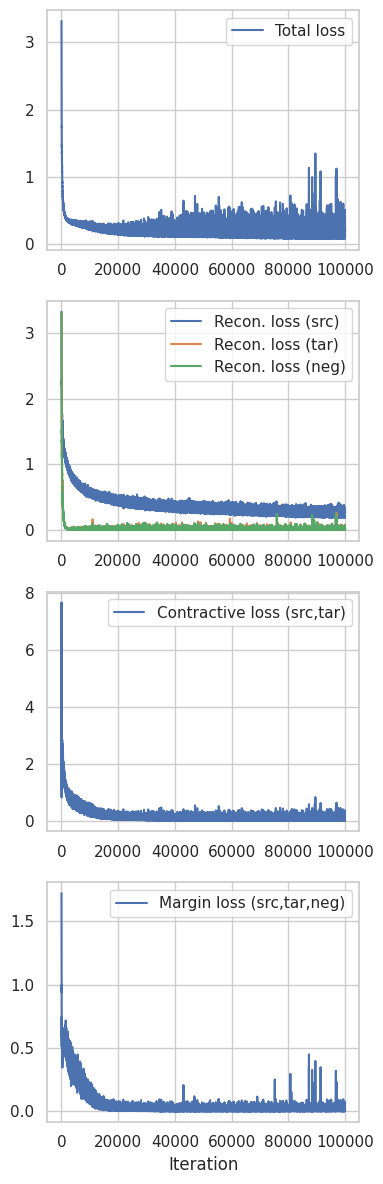

In [96]:
fig, axes = plt.subplots(4,1,figsize=(4,12))

axes[0].plot(df_history.loc[:,"LOSS_TOTAL"], label="Total loss")
axes[1].plot(df_history.loc[:,"LOSS_RECONSTRUCTION_SOURCE"], label="Recon. loss (src)")
axes[1].plot(df_history.loc[:,"LOSS_RECONSTRUCTION_TARGET"], label="Recon. loss (tar)")
axes[1].plot(df_history.loc[:,"LOSS_RECONSTRUCTION_NEGATIVE"], label="Recon. loss (neg)")
axes[2].plot(df_history.loc[:,"LOSS_CONTRACTIVE"], label="Contractive loss (src,tar)")
axes[3].plot(df_history.loc[:,"LOSS_MARGIN"], label="Margin loss (src,tar,neg)")

axes[3].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

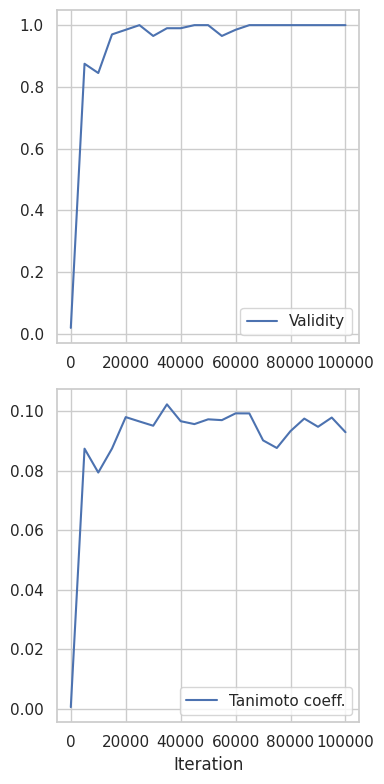

In [97]:
fig, axes = plt.subplots(2,1,figsize=(4,8))

axes[0].plot(df_history_valid.loc[:,"VALID_RATIO"], label="Validity")
axes[1].plot(df_history_valid.loc[:,"AVERAGE_SIMILARITY"], label="Tanimoto coeff.")

axes[1].set_xlabel("Iteration")
for ax in axes:
    ax.legend(loc='best')

plt.tight_layout()
plt.show()